In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [2]:
# Importar datos de insumos importados desde SIPA:
precios_insumos = pd.read_excel('data\precios-agroquimicos-fertilizantes.xlsx', sheet_name='histórico_mensual')

# Verticalizar dataframe:
precios_insumos = pd.melt(
    precios_insumos,
    id_vars=['Grupo', 'Ingrediente Activo', 'Concentración', 'Presentación'], 
    var_name='date',
    value_name='Precio'
    )

precios_insumos.head()

Grupo    Ingrediente Activo Concentración Presentación  \
0  Fungicidas         Propiconazol           0.25      1 litro   
1  Fungicidas  Cimoxanil + Mancozeb      8% + 64%   500 gramos   
2  Fungicidas           Carbendazim           0.5      1 litro   
3  Fungicidas          Clorotalonil          0.72      1 litro   
4  Herbicidas            Glifosato           0.48      1 litro   

                  date     Precio  
0  2013-01-01 00:00:00   26.17929  
1  2013-01-01 00:00:00   5.969885  
2  2013-01-01 00:00:00  14.446482  
3  2013-01-01 00:00:00  14.386754  
4  2013-01-01 00:00:00   4.576258

In [3]:
# Diccionario para homogeneizar ingrediente activo y concentración:
dict_ia_concentración = {
    'Propiconazol ': "propiconazol 25%",
    'Cimoxanil + Mancozeb': "cimoxanil 8% + mancozeb 64%",
    'Carbendazim': "carbendazim 50%",
    'Clorotalonil': "clorotalonil 72%",
    'Glifosato ': "glifosato 48%",
    'Paraquat': "paraquat 20%",
    'Pendimetalina': "pendimetalina 40%",
    'Propanil': "propanil 48%",
    '2,4-D Amina': "2.4-d amina 72%",
    'Atrazina 90%': "atrazina 90%",
    'Atrazina 80%': "atrazina 80%",
    'Clorpiriphos': "clorpiriphos 48%",
    'Cipermetrina': "cipermetrina 20%",
    'Fosfato Diamónico': "fosfato diamónico 18-46-0",
    'Muriato de Potasio': "muriato de potasio 0-0-60",
    'Urea': "urea 46-0-0"
    }

# Mapear datos ingredientes activos homogeneizados:
precios_insumos['ia_concentración'] = precios_insumos['Ingrediente Activo'].map(dict_ia_concentración)

In [4]:
# Extraer lista de fertilizantes presentes en el dataset:
lista_fertilizantes = list(precios_insumos[precios_insumos['Grupo'] == 'Fertilizantes']['ia_concentración'].unique())

# Extraer lista de plaguicidas:
lista_plaguicidas = list(precios_insumos[precios_insumos['Grupo'] != 'Fertilizantes']['ia_concentración'].unique())

In [5]:
# Formatear correctamente variable de precio: 
precios_insumos['Precio'] = precios_insumos['Precio'].apply(lambda x: np.nan if x == '-' else x)

precios_insumos['Precio'] = pd.to_numeric(precios_insumos['Precio'], errors='coerce')

Homogeneizar "precio (USD)/unidad de medida" entre insumos. Para efecto, convertimos gramos a kilogramos. La unidad de los insumos líquidos es el litro. 

In [6]:
# Homogeneizar variable de presentación para transformar unidades:
precios_insumos['Presentación'] = precios_insumos['Presentación']\
    .apply(preprocess_text)\
    .str.replace('gramos', 'g')\
    .str.replace('litro', 'l')

print(precios_insumos['Presentación'].unique())

# Extraer unidad de presentación:
precios_insumos['unidad_presentación'] = precios_insumos['Presentación'].str.split(' ').str[1]

# Extraer cantidad de presentación y convertir a float:
precios_insumos['cantidad_presentación'] = precios_insumos['Presentación'].str.split(' ').str[0].astype(float)

# Convertir cantidades en gramos a kilogramos, homologando unidades:
precios_insumos['cantidad_presentación_homologado'] = precios_insumos['cantidad_presentación'].copy()

condición_gramos = precios_insumos['unidad_presentación'] == 'g'
precios_insumos.loc[condición_gramos, 'cantidad_presentación_homologado'] = precios_insumos['cantidad_presentación'] / 1000

# Crear columna de unidades homologadas:
precios_insumos['unidad_presentación_homologado'] = precios_insumos['unidad_presentación'].replace(to_replace={'g': 'kg'})

# Una vez homologadas las unidades, calcular precio unitario:
precios_insumos['precio_unidad_homologada'] =  precios_insumos['Precio'] / precios_insumos['cantidad_presentación_homologado']


['1 l' '500 g' '900 g' '1 kg' '50 kg']


In [7]:
# Transformar variable de fecha a formato estándar, convertir a formato correcto y establecer a último día del mes:
precios_insumos['date'] = pd.to_datetime(precios_insumos['date'], format='%b-%y') + pd.offsets.MonthEnd(0)

# Pivotar la tabla para convertir los insumos en columnas con sus precios históricos:
precios_insumos = precios_insumos.pivot(index='date', columns='ia_concentración', values='precio_unidad_homologada')

# Eliminar el nombre del conjunto de columnas 'ia_concentración':
precios_insumos.columns.name = None

precios_insumos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   2.4-d amina 72%              140 non-null    float64
 1   atrazina 80%                 81 non-null     float64
 2   atrazina 90%                 129 non-null    float64
 3   carbendazim 50%              105 non-null    float64
 4   cimoxanil 8% + mancozeb 64%  140 non-null    float64
 5   cipermetrina 20%             140 non-null    float64
 6   clorotalonil 72%             140 non-null    float64
 7   clorpiriphos 48%             140 non-null    float64
 8   fosfato diamónico 18-46-0    140 non-null    float64
 9   glifosato 48%                140 non-null    float64
 10  muriato de potasio 0-0-60    140 non-null    float64
 11  paraquat 20%                 140 non-null    float64
 12  pendimetalina 40%            140 non-null    float64
 13  p

In [8]:
primer_mes_análisis = precios_insumos.index.min()
último_mes_análisis = precios_insumos.index.max()

primer_mes_análisis_imprimir = primer_mes_análisis.strftime('%B %Y')
último_mes_análisis_imprimir = último_mes_análisis.strftime('%B %Y')

print("primer mes de análisis: ", primer_mes_análisis_imprimir)
print("último mes de análisis: ", último_mes_análisis_imprimir)

primer mes de análisis:  enero 2013
último mes de análisis:  agosto 2024


### Precios Fertilizantes

In [9]:
# Filtrar columnas de fertilizantes:
precios_fertilizantes = precios_insumos[lista_fertilizantes]

precios_fertilizantes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fosfato diamónico 18-46-0  140 non-null    float64
 1   muriato de potasio 0-0-60  140 non-null    float64
 2   urea 46-0-0                140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


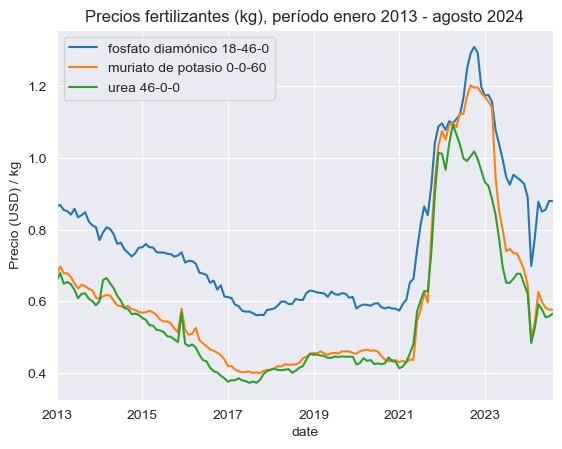

In [10]:
precios_fertilizantes.plot()
plt.title(f"Precios fertilizantes (kg), período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD) / kg")
plt.show()

### FOB urea del Mar Negro

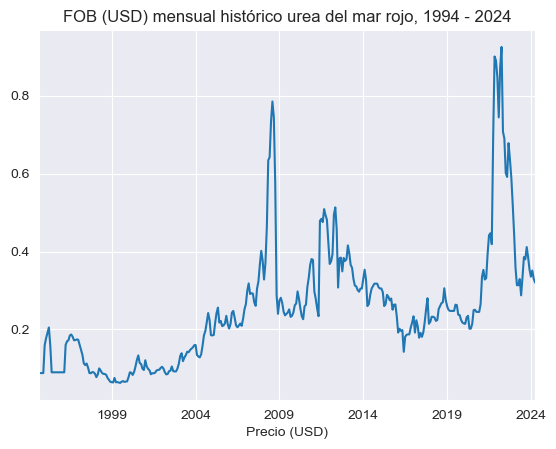

In [199]:
fob_urea_mar_rojo_histórico = pd.read_excel('data/fob_black_sea_urea.xlsx')\
    .rename(columns={"Month": "date"})\
        
fob_urea_mar_rojo_histórico['date'] = fob_urea_mar_rojo_histórico['date']  + pd.offsets.MonthEnd(0)
fob_urea_mar_rojo_histórico = fob_urea_mar_rojo_histórico.set_index('date')

fob_urea_mar_rojo_histórico['fob_urea_kg'] = fob_urea_mar_rojo_histórico['Price'] / 1000

fob_urea_mar_rojo_histórico['fob_urea_kg'].plot()
plt.title(f"FOB (USD) mensual histórico urea del mar rojo, {fob_urea_mar_rojo_histórico.index.year.min()} - {fob_urea_mar_rojo_histórico.index.year.max()}")
plt.xlabel("Precio (USD)")
plt.show()

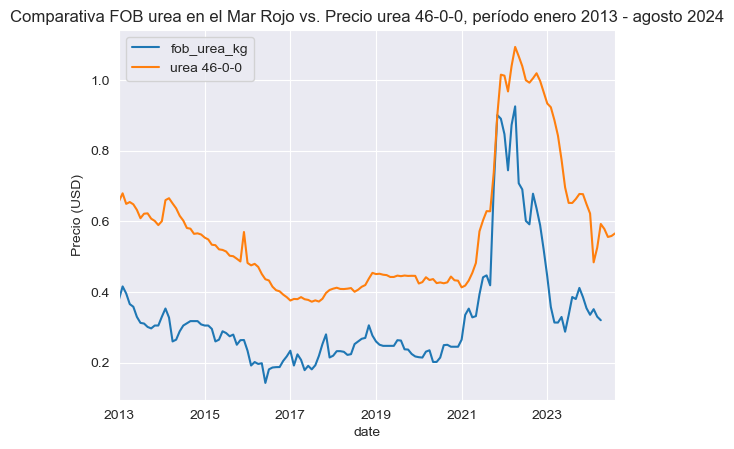

In [12]:
fob_urea_mar_rojo = fob_urea_mar_rojo_histórico[['fob_urea_kg']][primer_mes_análisis:último_mes_análisis]


fob_urea_mar_rojo['fob_urea_kg'].plot()
precios_fertilizantes['urea 46-0-0'].plot()
plt.title(f"Comparativa FOB urea en el Mar Rojo vs. Precio urea 46-0-0, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()


### Gas natural y crudo Brent Europa

In [13]:
# Importar datos de CMO:
precio_commodities_Europa = pd.read_excel(
    'data\CMO-Historical-Data-Monthly.xlsx',
    skiprows=4,
    sheet_name='Monthly Prices',
    header=None
    )

# Fusionar la primera fila con la segunda para crear nombres de columnas:
precio_commodities_Europa.loc[0] = precio_commodities_Europa.loc[0].fillna('') + ' ' + precio_commodities_Europa.loc[1].fillna('')

# Formatear primera fila:
precio_commodities_Europa.loc[0] = precio_commodities_Europa.loc[0]\
    .apply(preprocess_text, keep_characters='$/')\
    .str.replace(' ', '_')\
    .str.replace('$/', 'usd_per_')\

# Establecer primera fila como nombres de columnas:
precio_commodities_Europa.columns = precio_commodities_Europa.loc[0]

# Filtrar filas y columnas útiles:
precio_commodities_Europa = precio_commodities_Europa[
    ['date', 'crude_oil_brent_usd_per_bbl', 'natural_gas_europe_usd_per_mmbtu']
    ]\
        .drop([0, 1])

# Formatear correctamente la columna de fechas:
precio_commodities_Europa['date'] = pd.to_datetime(
    precio_commodities_Europa['date']\
        .str.replace('M', '-')\
        + '-01'
    ) + pd.offsets.MonthEnd(0)

# Establecer columna de fechas como índice y filtrar años de análisis:
precio_commodities_Europa = precio_commodities_Europa\
    .set_index('date')\
        [primer_mes_análisis:último_mes_análisis]

# Convertir columnas de crudo y gas a formato numérico correcto:
for col in ['crude_oil_brent_usd_per_bbl', 'natural_gas_europe_usd_per_mmbtu']:
    precio_commodities_Europa[col] = precio_commodities_Europa[col].astype(float)

precio_commodities_Europa.columns.name = None

precio_commodities_Europa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   crude_oil_brent_usd_per_bbl       140 non-null    float64
 1   natural_gas_europe_usd_per_mmbtu  140 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


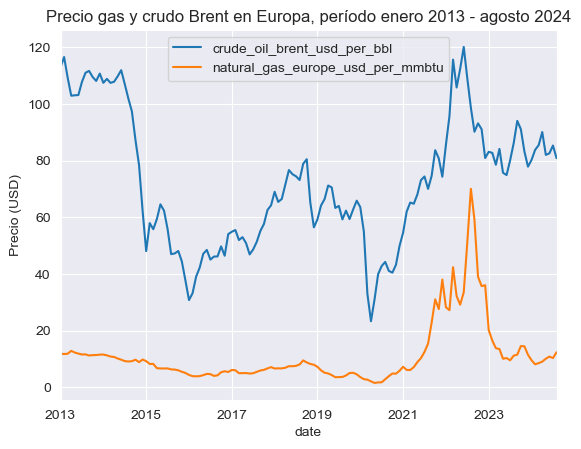

In [14]:
precio_commodities_Europa.plot()
plt.title(f"Precio gas y crudo Brent en Europa, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.show()

In [15]:
np.corrcoef(precios_fertilizantes['urea 46-0-0'], precio_commodities_Europa['natural_gas_europe_usd_per_mmbtu'])[0,1]

0.8500528831311174

### Inflación

In [16]:
inflación_mensual = pd.read_csv('data\inflación_mensual.csv')

inflación_mensual['Inflación mensual general'] = inflación_mensual['Inflación mensual general'].str.replace(',', '.')

inflación_mensual_nacional = inflación_mensual\
    .rename(columns={
        'Mes': 'date',
        'Inflación mensual general': 'inflación_mensual'
        })\
    .astype({
        'date': 'datetime64[ns]',
        'inflación_mensual': 'float'
        })\
    [inflación_mensual['Región'] == 'NACIONAL']\
    .drop(columns=['Año', 'Región'])#

inflación_mensual_nacional['date'] = pd.to_datetime(inflación_mensual_nacional['date']) + pd.offsets.MonthEnd(0)

inflación_mensual_nacional = inflación_mensual_nacional\
    .set_index('date')\
    [primer_mes_análisis:último_mes_análisis]

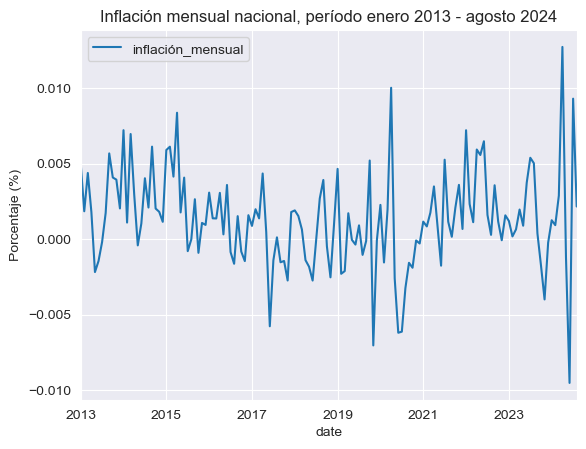

In [17]:
inflación_mensual_nacional.plot()
plt.title(f"Inflación mensual nacional, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Porcentaje (%)")
plt.show()

### Precios combustibles

https://fiduvalor.com.ec/2024/06/24/la-eliminacion-de-subsidios-y-la-evolucion-del-precio-de-la-gasolina-en-ecuador/

In [18]:
# Cargar IPC de combustibles:
ipc_combustibles = pd.read_excel('data\precios-combustibles.xlsx')

# Establecer columna de fechas como índice: 
ipc_combustibles['date'] = pd.to_datetime(ipc_combustibles['date']) + pd.offsets.MonthEnd(0)

# Ordenar dataframe por fecha:
ipc_combustibles = ipc_combustibles\
    .sort_values(by='date')\
    .set_index('date')\
    # [primer_mes_análisis:último_mes_análisis]

# Extraer diesel como el combustible de uso común en transporte de insumos agropecuarios.
ipc_diesel = ipc_combustibles[['diesel']]

In [19]:
# Constantes de precio de combustible diésel extraído de datos de CEPAL:
precio_diesel_2013 = 0.272
precio_diesel_2014 = 0.274 # Año base IPC (INEC 2023)

# Calcular IPC diésel 2013:
ipc_diesel_2013 = round(precio_diesel_2013 / precio_diesel_2014 *100, 6)

# Crear rango de fechas a inferir, meses 2013-2014:
index_inferencias = pd.date_range(start='2013-01', end='2015-01', freq='ME')

# Crear DataFrame de precios de combustibles inferidos:
ipc_combustibles_inferidos = pd.DataFrame()

# Establecer índice de fechas a inferir:
ipc_combustibles_inferidos['date'] = index_inferencias
ipc_combustibles_inferidos.set_index('date', inplace=True)

# Mapear ipc_diesel_2013 para meses de 2013:
condición_año_2013 = (ipc_combustibles_inferidos.index.year == 2013)
ipc_combustibles_inferidos.loc[condición_año_2013, 'diesel'] = ipc_diesel_2013

# Completar IPC de año 2014 (año base):
ipc_combustibles_inferidos = ipc_combustibles_inferidos.fillna(100)

# Unir datos inferidos con los originales:
ipc_diesel_imp = pd.concat(
    [ipc_combustibles_inferidos, ipc_diesel],
    axis=0
    )

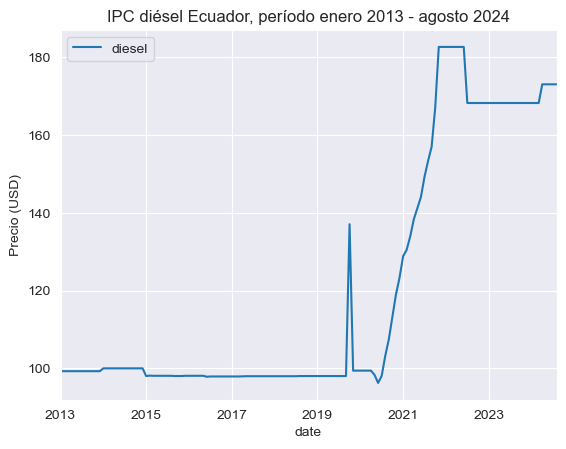

In [20]:
# Graficar precios de combustibles:
ipc_diesel_imp.plot()
plt.title(f"IPC diésel Ecuador, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.show()

### Precios WTI

In [21]:
precios_históricos_wti = pd.read_excel('data\Cushing_OK_WTI_Spot_Price_FOB.xlsx')

# Convertir las columnas a formato largo (melt)
precios_históricos_wti = precios_históricos_wti.melt(
    id_vars=["Year"],
    var_name="Month",
    value_name="precio_wti"
    )

# Crear la columna 'date' a partir de 'Year' y 'Month'
precios_históricos_wti['date'] = pd.to_datetime(
    precios_históricos_wti['Year'].astype(str) + '-' + precios_históricos_wti['Month'].str.lower() + '-01',
    format='mixed'
    ) + pd.offsets.MonthEnd(0)

# Ordenar por fecha y filtrar variables útiles:
precios_históricos_wti = precios_históricos_wti\
    .sort_values('date')\
        [['date', 'precio_wti']]\
            .set_index('date')
        

# Ordenar por 'date' y establecer como índice; filtrar por período de análisis:
precios_wti = precios_históricos_wti[primer_mes_análisis:último_mes_análisis]

precios_wti.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   precio_wti  140 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


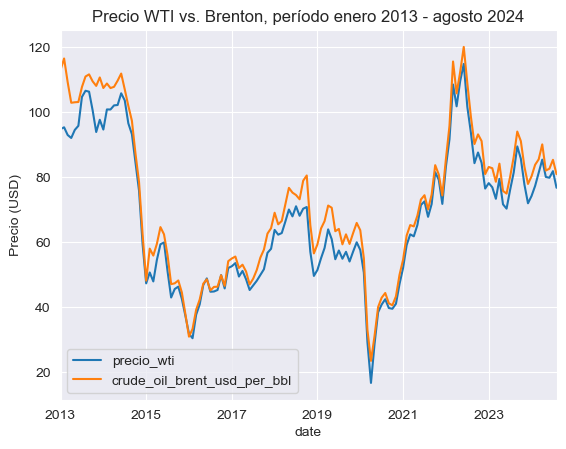

In [22]:
precios_wti.plot()
precio_commodities_Europa['crude_oil_brent_usd_per_bbl'].plot()
plt.title(f"Precio WTI vs. Brenton, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()

In [23]:
# Correlación precio de crudo Brenton versus WTI, período:
precio_commodities_Europa['crude_oil_brent_usd_per_bbl'].corr(precios_wti['precio_wti'])

0.9913363529140942

### Datos climáticos

In [24]:
archivo_cckp = 'data\era5-x0.25_timeseries_pr,tas_timeseries_monthly_1950-2022_mean_historical_era5_x0.25_mean.xlsx'
hojas_excel = ['pr', 'tas']
dict_datos_climáticos_histórico = {}

for hoja in hojas_excel:
    dict_datos_climáticos_histórico[hoja] = pd.read_excel(archivo_cckp, sheet_name=hoja)\
        .drop(columns=['code', 'name'])\
        .T\
        .reset_index()
    
    dict_datos_climáticos_histórico[hoja].columns = ['date', hoja]
    
datos_climáticos_histórico = pd.merge(
    dict_datos_climáticos_histórico['pr'],
    dict_datos_climáticos_histórico['tas'],
    on='date',
    how='inner'
    )\
        .rename(columns={'pr': 'precipitación_media_mm', 'tas':'temp_media_Celsius'})

datos_climáticos_histórico['date'] = pd.to_datetime(datos_climáticos_histórico['date'] + '-01') + pd.offsets.MonthEnd(0)

datos_climáticos_histórico.set_index('date', inplace=True)

datos_climáticos_histórico.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 876 entries, 1950-01-31 to 2022-12-31
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   precipitación_media_mm  876 non-null    float64
 1   temp_media_Celsius      876 non-null    float64
dtypes: float64(2)
memory usage: 20.5 KB


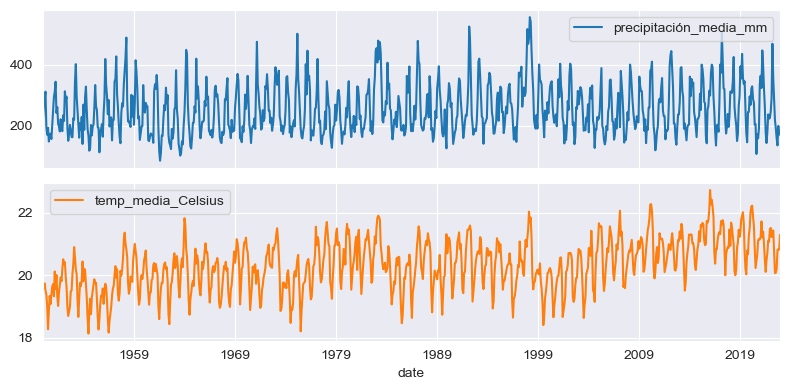

In [25]:
datos_climáticos_histórico.plot(subplots=True, figsize=(8, 4))
plt.tight_layout()
plt.show()


#### Imputación provisional de datos climáticos para 2023

In [26]:
# Calcular los promedios mensuales históricos:
promedios_mensuales = datos_climáticos_histórico[datos_climáticos_histórico.index.year < 2023].groupby(datos_climáticos_histórico.index.month).mean()

# Crear el índice con fechas hasta diciembre de 2023 y reindexar el DataFrame
nuevo_índice = pd.date_range(start=datos_climáticos_histórico.index.min(), end="2023-12-31", freq='ME')
datos_climáticos_imputados = datos_climáticos_histórico.reindex(nuevo_índice)

# Serie de número de mes con índice de fechas:
serie_num_mes = pd.Series(datos_climáticos_imputados.index.month, index=datos_climáticos_imputados.index)
variables_clima = ['temp_media_Celsius', 'precipitación_media_mm']

# Iterar sobre variables de clima:
for col in variables_clima:
    
    # Mapear los promedios mensuales en los valores nulos, utilizando la serie de meses:
    datos_climáticos_imputados[col] = datos_climáticos_imputados[col].fillna(serie_num_mes.map(promedios_mensuales[col]))

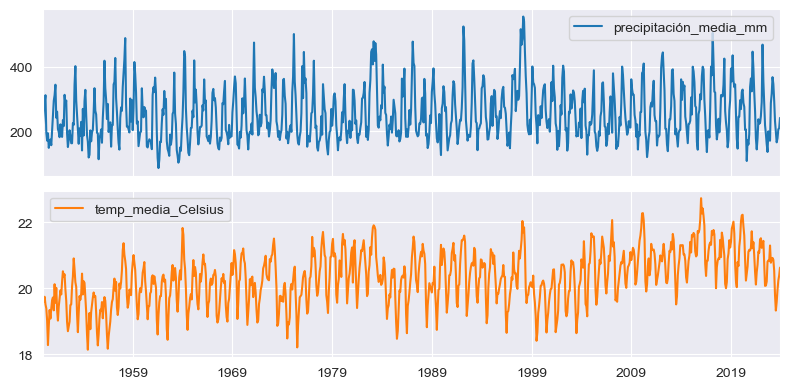

In [27]:
datos_climáticos_imputados.plot(subplots=True, figsize=(8, 4))
plt.tight_layout()
plt.show()

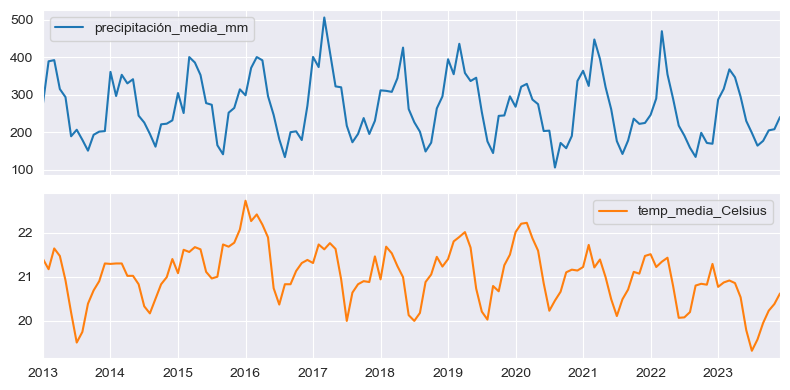

In [28]:
# Filtrar datos para período de análisis:
datos_climáticos = datos_climáticos_imputados[primer_mes_análisis:último_mes_análisis]

datos_climáticos.plot(subplots=True, figsize=(8, 4))
plt.tight_layout()
plt.show()

#### Datos SIPA

In [29]:
# Datos de temperatura y precipitaciones SIPA:
datos_climáticos_histórico_sipa = pd.read_excel(r'data\temperatura-precipitacion-sipa-2024.xls', sheet_name='Temperatura y Precipitación', skiprows=7)

datos_climáticos_histórico_sipa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25668 entries, 0 to 25667
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Año                        25668 non-null  int64  
 1   Mes                        25668 non-null  object 
 2   Estación                   25668 non-null  object 
 3   Provincia                  25668 non-null  object 
 4   Cantón                     25668 non-null  object 
 5   Precipitación (mm)         21323 non-null  float64
 6   Temperatura promedio (°C)  16861 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB


In [30]:
datos_climáticos_histórico_sipa['Provincia'] = datos_climáticos_histórico_sipa['Provincia'].replace('0', 'No determinado')

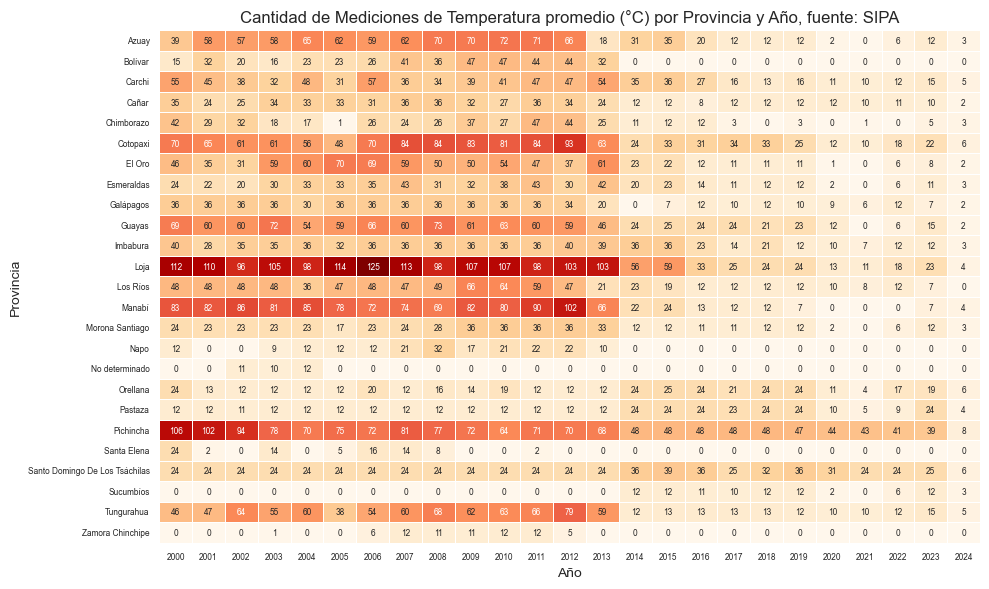

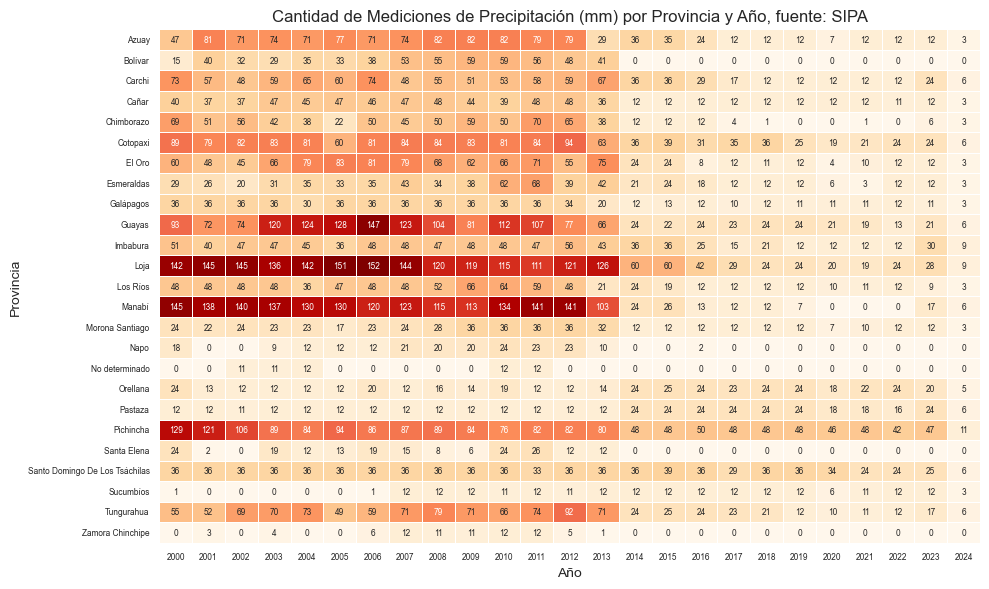

In [31]:
variables_clima = ['Temperatura promedio (°C)', 'Precipitación (mm)']
dict_mediciones_por_provincia_y_año = {}

for col in variables_clima:
    dict_mediciones_por_provincia_y_año[col] = pd.crosstab(
        index=datos_climáticos_histórico_sipa['Provincia'],  # Filas: Provincias
        columns=datos_climáticos_histórico_sipa['Año'],      # Columnas: Años
        values=datos_climáticos_histórico_sipa[col],  # Variable a contar
        aggfunc='count'  # Función para contar observaciones válidas
        )\
            .fillna(0)\
            .astype(int)

    plt.figure(figsize=(10, 6))
    sns.heatmap(dict_mediciones_por_provincia_y_año[col], cmap='OrRd', linewidths=0.5, annot=True, fmt=".0f", annot_kws={"size": 6}, cbar=False)

    # Ajustar las etiquetas para mejorar la visibilidad
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.title(f'Cantidad de Mediciones de {col} por Provincia y Año, fuente: SIPA')
    plt.tight_layout()
    plt.show()

In [32]:
# Agregar datos para obtener valores medios nacionales:
datos_climáticos_histórico_sipa = datos_climáticos_histórico_sipa\
    .rename(columns={'Precipitación (mm)': 'precipitación_media_mm', 'Temperatura promedio (°C)':'temp_media_Celsius'})\
    .groupby(['Año', 'Mes'])\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()

In [33]:
# Diccionario para mapear meses por sus equivalentes numéricos:
meses = {
    'Enero': '01',
    'Febrero': '02',
    'Marzo': '03',
    'Abril': '04',
    'Mayo': '05',
    'Junio': '06',
    'Julio': '07',
    'Agosto': '08',
    'Septiembre': '09',
    'Octubre': '10',
    'Noviembre': '11',
    'Diciembre': '12'
    }

# Crear la columna de fecha combinando 'Año' y 'Mes':
datos_climáticos_histórico_sipa['date'] = pd.to_datetime(
    datos_climáticos_histórico_sipa['Año'].astype(str) + \
    '-' + \
    datos_climáticos_histórico_sipa['Mes'].map(meses)
    ) + pd.offsets.MonthEnd(0)  # Ajusta al último día del mes

datos_climáticos_histórico_sipa = datos_climáticos_histórico_sipa\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['Año', 'Mes'])\
    [primer_mes_análisis:]

Correlación precipitación_media_mm:  0.8997581228437685
Correlación temp_media_Celsius:  0.4648387155413048


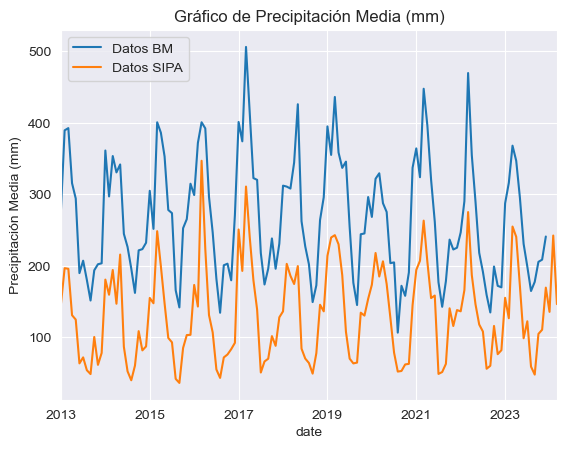

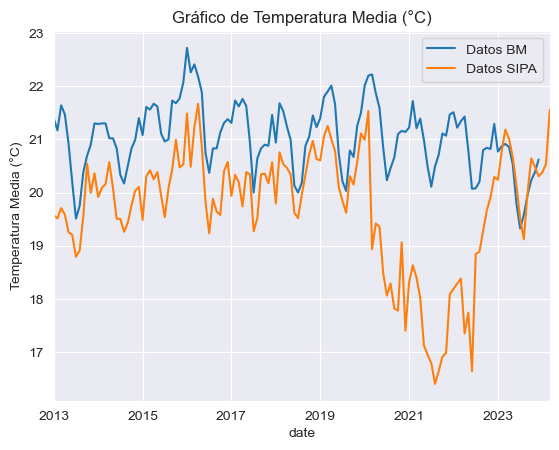

In [34]:
# Revisamos correlaciones entre fuentes de datos distintas:
for col in ('precipitación_media_mm', 'temp_media_Celsius'):
    print(f"Correlación {col}: ", datos_climáticos_histórico[col].corr(datos_climáticos_histórico_sipa[col][:'2022']))

# Gráfica para precipitación_media_mm
datos_climáticos['precipitación_media_mm'].plot(label='Datos BM')
datos_climáticos_histórico_sipa['precipitación_media_mm'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Precipitación Media (mm)')
plt.xlabel('date')
plt.ylabel('Precipitación Media (mm)')
plt.show()

# Gráfica para temp_media_Celsius
datos_climáticos['temp_media_Celsius'].plot(label='Datos BM')
datos_climáticos_histórico_sipa['temp_media_Celsius'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Temperatura Media (°C)')
plt.xlabel('date')
plt.ylabel('Temperatura Media (°C)')
plt.show()


### Importaciones de Insumos Agrícolas

In [35]:
importación_insumos_agrícolas = pd.read_excel('data\importaciones_cif_por_uso.xlsx', sheet_name='insumos_agrícolas')

importación_insumos_agrícolas.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

importación_insumos_agrícolas['date'] = pd.to_datetime(
    importación_insumos_agrícolas['Año'].astype(str) +\
    '-' + \
    importación_insumos_agrícolas['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

importación_insumos_agrícolas['código'] = importación_insumos_agrícolas['código'].astype(str)

importación_insumos_agrícolas = importación_insumos_agrícolas\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor CIF dólar en miles': 'cif_miles_usd',
        'Matricero': 'matricero_insumos'
        })\
            [primer_mes_análisis:último_mes_análisis]\

importación_insumos_agrícolas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1443 entries, 2013-01-31 to 2023-10-31
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   matricero_insumos  1443 non-null   object 
 1   Código Matricero   1443 non-null   object 
 2   cif_miles_usd      1443 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.1+ KB


In [36]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_insumos = importación_insumos_agrícolas.pivot_table(
    values='cif_miles_usd', 
    index='date', 
    columns='matricero_insumos', 
    aggfunc='sum',
    fill_value=0
    )

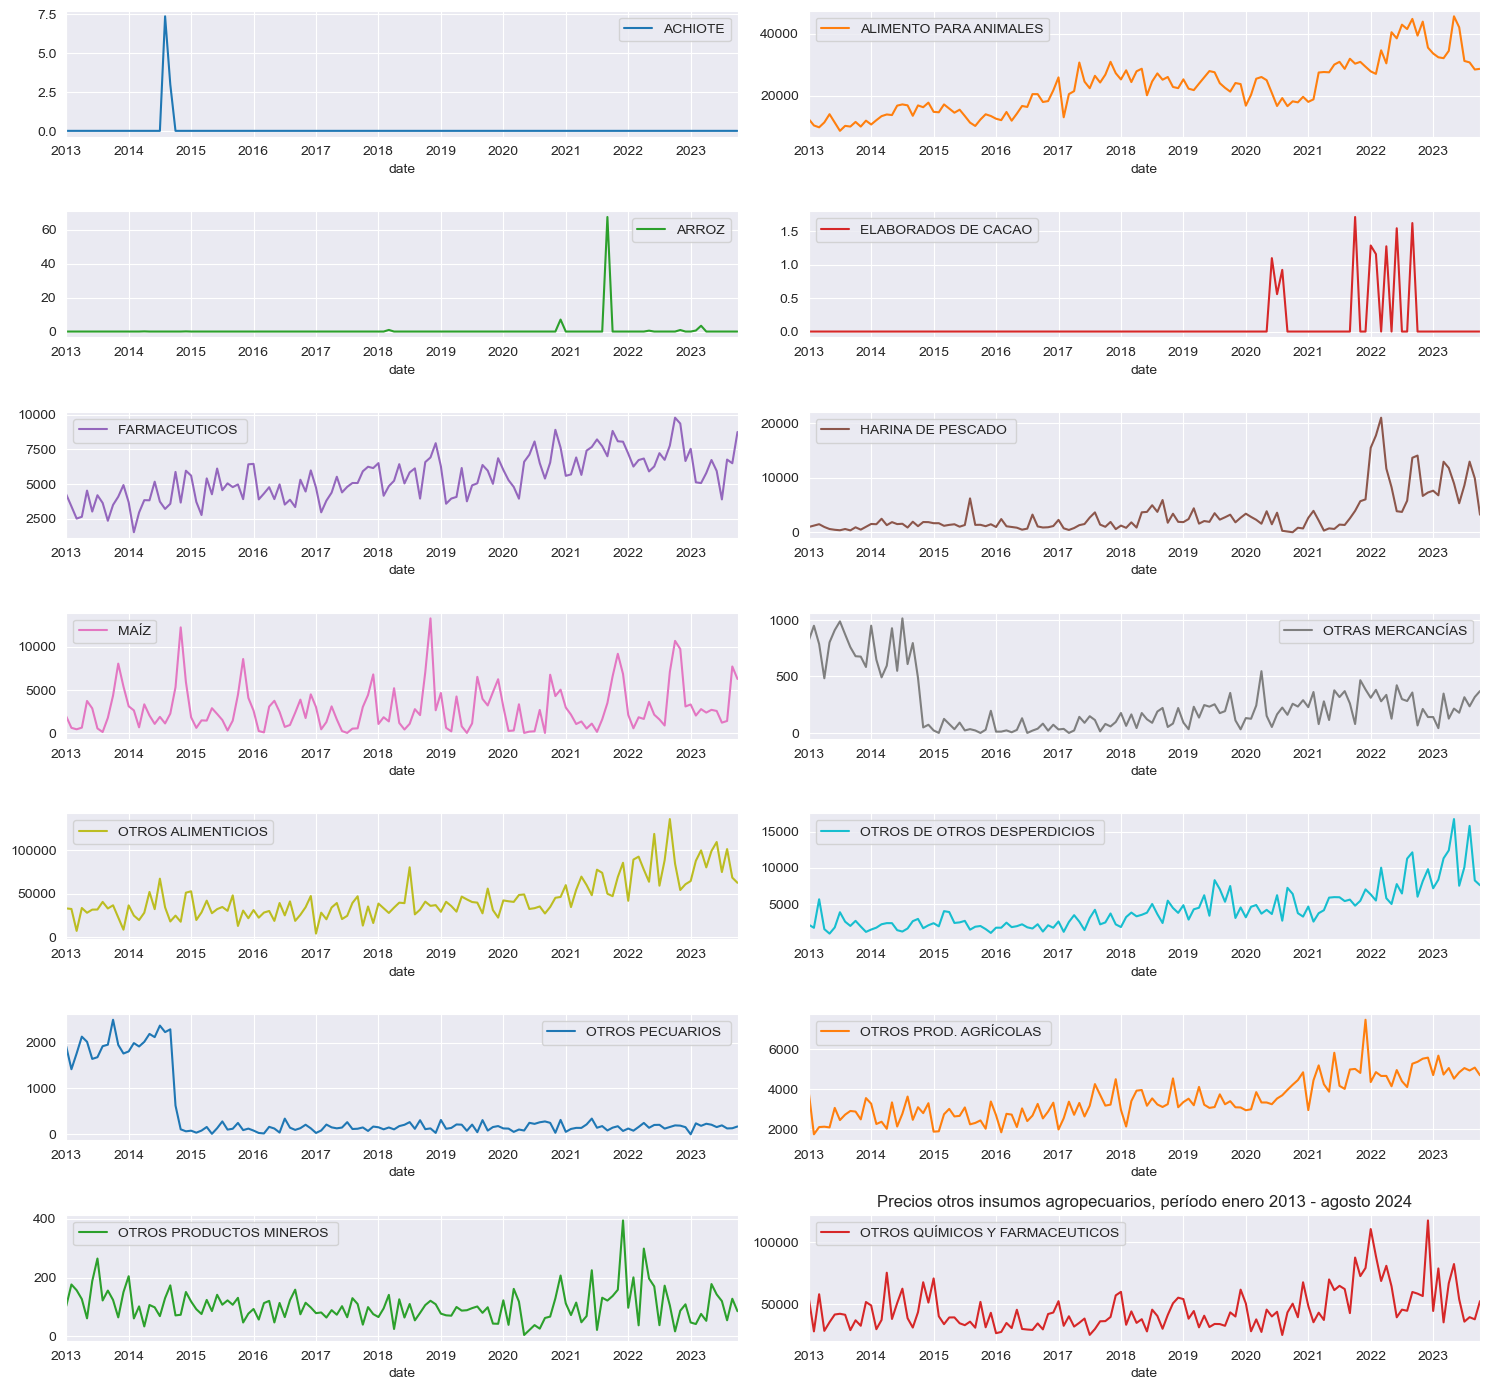

In [37]:
num_de_filas = ((X_insumos.shape[1] + 1) // 2)

X_insumos.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.title(f"Precios otros insumos agropecuarios, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.tight_layout()
plt.show()

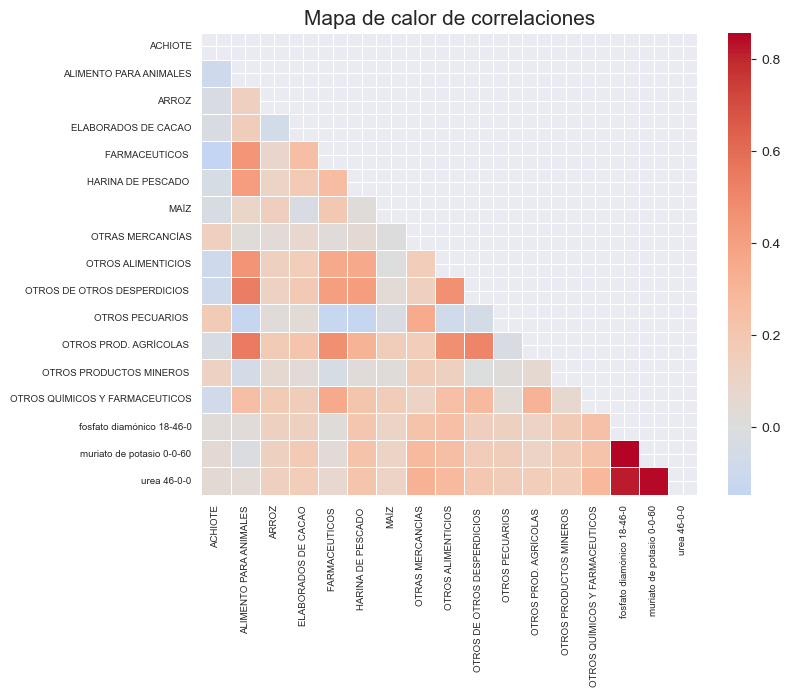

In [229]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
importación_insumos_agrícolas_y_fertilizantes = X_insumos.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = importación_insumos_agrícolas_y_fertilizantes.corr(method="kendall")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot_kws={"size": 6})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()


### Exportaciones

In [239]:
# Importar exportaciones:
exportaciones = pd.read_excel(
    'data\\08. Export. por Producto Principal (nivel 4).xlsx',
    sheet_name='Consulta 1',
    usecols=['date', 'Código Matricero', 'Matricero', 'Valor Peso Neto en miles', 'Valor FOB Dólar bajo Selección']
    )\
        .rename(columns={
            'Código Matricero': 'código',
            'Matricero': 'producto_exportado',
            'Valor Peso Neto en miles': 'peso_neto_miles',
            'Valor FOB Dólar bajo Selección': 'fob_miles_usd'
            }
        )\
        .set_index('date')

exportaciones.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198316 entries, 2013-04-11 to 2024-05-31
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   producto_exportado  198316 non-null  object 
 1   código              198316 non-null  int64  
 2   peso_neto_miles     198316 non-null  float64
 3   fob_miles_usd       198316 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.6+ MB


In [242]:
# Ajustar tipo de datos de 'código':
exportaciones['código'] = exportaciones['código'].astype(str)

# Filtrar únicamente exportaciones agrícolas:
exportaciones_agrícolas = exportaciones[exportaciones['código'].str.startswith('11')]

# Agrupar exportaciones agrícolas por producto y año mes, sumando los valores:
exportaciones_agrícolas_agrupadas = exportaciones_agrícolas\
    .groupby(['código', 'producto_exportado', exportaciones_agrícolas.index.to_period('M')])\
        [['peso_neto_miles', 'fob_miles_usd']]\
            .sum()\
    .reset_index()

# Redefinir columna de fecha:
exportaciones_agrícolas_agrupadas['date'] = exportaciones_agrícolas_agrupadas['date'].dt.to_timestamp() + pd.offsets.MonthEnd(0)
# exportaciones_agrícolas_agrupadas = exportaciones_agrícolas_agrupadas.set_index('date')

# Convertir nombres de productos a minúsculas:
exportaciones['producto_exportado'] = exportaciones['producto_exportado']\
    .str.lower()\
    .apply(preprocess_text)

exportaciones_agrícolas_agrupadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   código              2138 non-null   object        
 1   producto_exportado  2138 non-null   object        
 2   date                2138 non-null   datetime64[ns]
 3   peso_neto_miles     2138 non-null   float64       
 4   fob_miles_usd       2138 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 83.6+ KB


In [244]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_exportaciones = exportaciones_agrícolas_agrupadas.pivot_table(
    index='date',
    columns='producto_exportado',
    values='fob_miles_usd',
    aggfunc='sum'
    )\
        [primer_mes_análisis:último_mes_análisis]\
            .dropna(axis=1, how='any') # Elimina una columna si contienen algún valor nulo

X_exportaciones.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   abaca                   140 non-null    float64
 1   banano                  140 non-null    float64
 2   cacao                   140 non-null    float64
 3   cafe lavado             140 non-null    float64
 4   flores naturales        140 non-null    float64
 5   hojas de te             140 non-null    float64
 6   otras fibras vegetales  140 non-null    float64
 7   otras frutas            140 non-null    float64
 8   otros prod agricolas    140 non-null    float64
 9   pinas                   140 non-null    float64
 10  platano                 140 non-null    float64
 11  tabaco en rama          140 non-null    float64
dtypes: float64(12)
memory usage: 14.2 KB


In [246]:
# Obtener lista de productos ordenada por volumen total de exportación como FOB, 2013-2023:
orden_de_volumen = X_exportaciones.sum().sort_values(ascending=False).index

# Ordenar datos por volumen total de exportación:
X_exportaciones = X_exportaciones[orden_de_volumen]

X_exportaciones.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   banano                  140 non-null    float64
 1   flores naturales        140 non-null    float64
 2   cacao                   140 non-null    float64
 3   otras frutas            140 non-null    float64
 4   platano                 140 non-null    float64
 5   otros prod agricolas    140 non-null    float64
 6   tabaco en rama          140 non-null    float64
 7   pinas                   140 non-null    float64
 8   abaca                   140 non-null    float64
 9   cafe lavado             140 non-null    float64
 10  hojas de te             140 non-null    float64
 11  otras fibras vegetales  140 non-null    float64
dtypes: float64(12)
memory usage: 14.2 KB


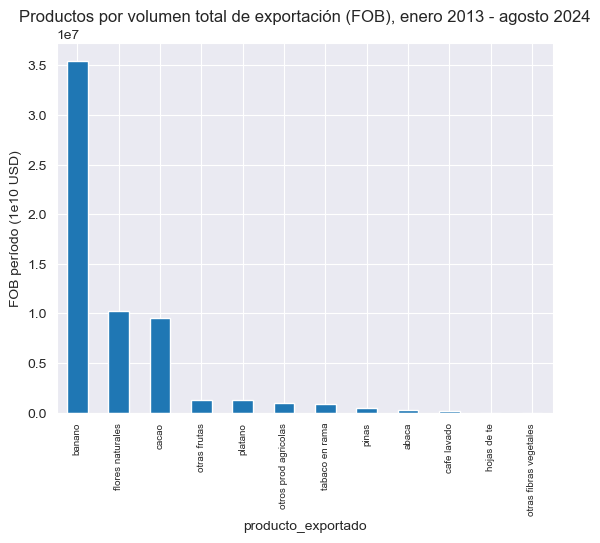

In [247]:
# Visualizar volumen de exportaciones por producto en el período:
X_exportaciones.sum().plot(kind='bar')
plt.title(f"Productos por volumen total de exportación (FOB), {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.ylabel("FOB período (1e10 USD)")
plt.xticks(size=7)
plt.show()


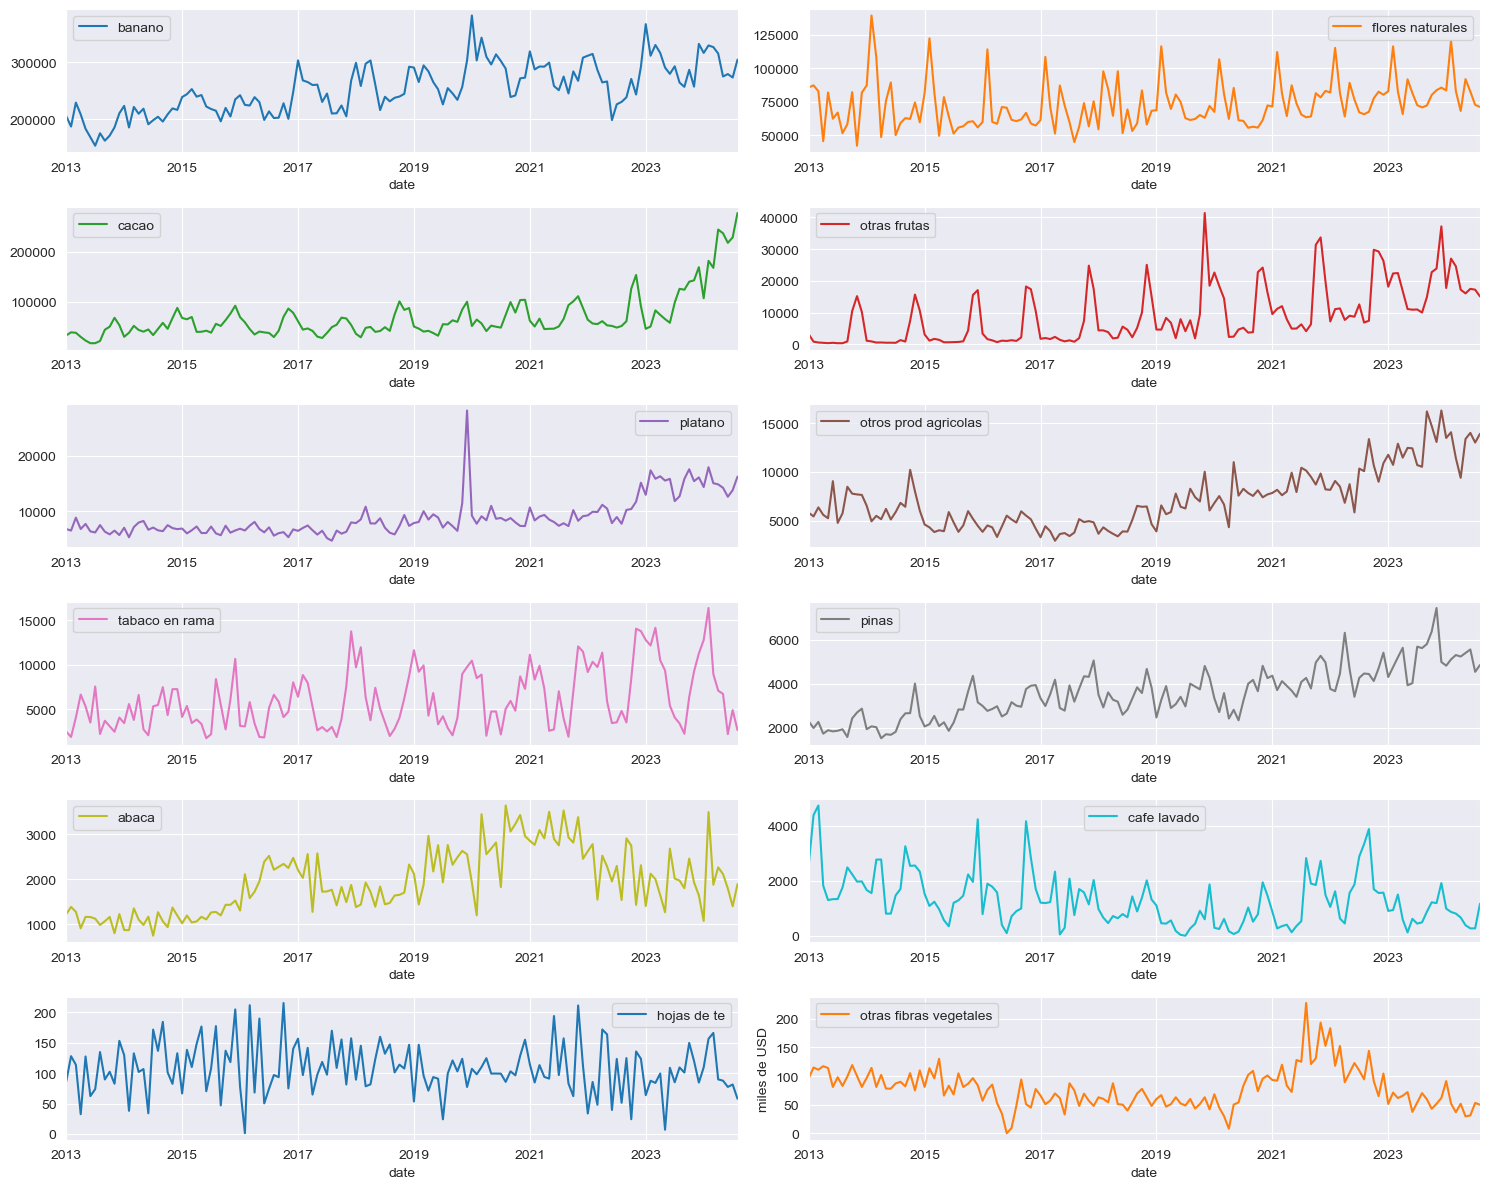

In [248]:
num_de_filas = ((X_exportaciones.shape[1] + 1) // 2)

X_exportaciones.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )

plt.ylabel("miles de USD")
# plt.title(f"FOB exportaciones de productos agrícolas, período {primer_mes_análisis_imprimir} - {último_mes_análisis_imprimir}")
plt.tight_layout()
plt.show()

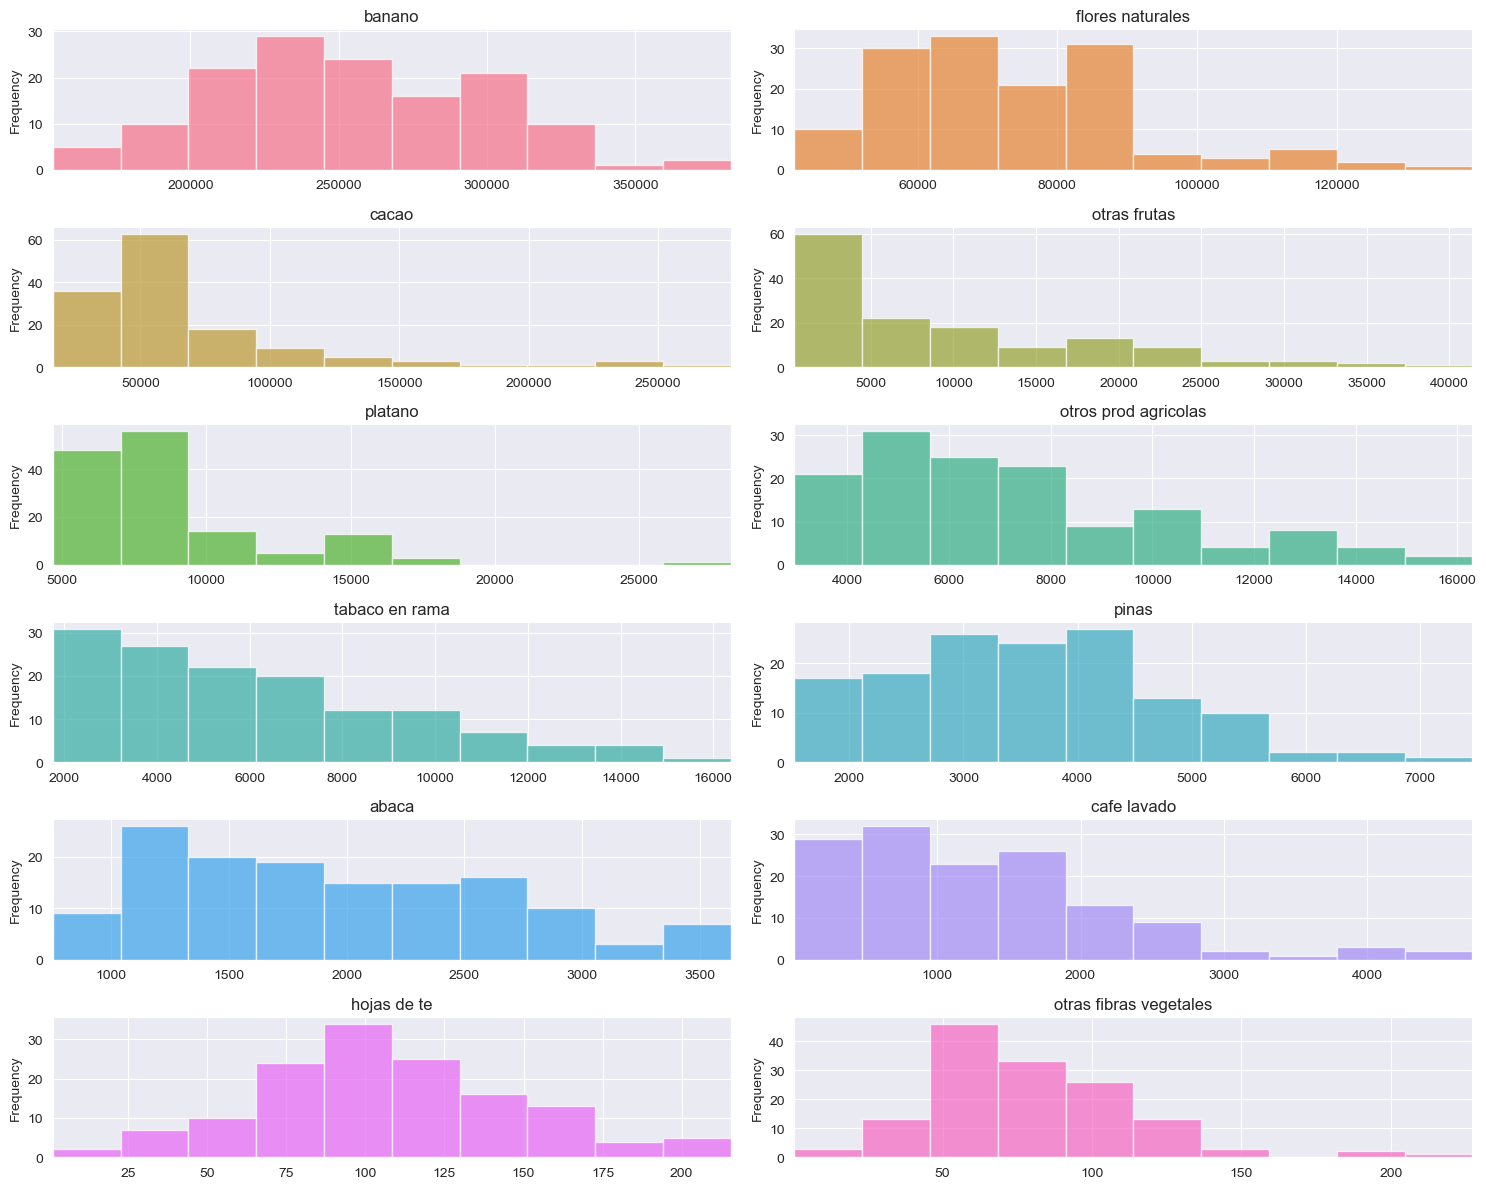

In [249]:
# Crear la figura y los subplots
fig, axes = plt.subplots(nrows=num_de_filas, ncols=2, figsize=(15, 2 * num_de_filas))

# Aplanar los ejes para facilitar la iteración
axes = axes.flatten()

# Usar una paleta de colores de seaborn para colores automáticos
colores = sns.color_palette('husl', len(X_exportaciones.columns))  # Paleta "husl" para diferentes colores

# Iterar sobre las columnas de X_exportaciones para graficar cada histograma
for i, (ax, column, color) in enumerate(zip(axes, X_exportaciones.columns, colores)):
    
    # Graficar el histograma de cada variable con su propio color
    X_exportaciones[column].plot(
        kind='hist',
        bins=10,  # Ajusta el número de bins si es necesario
        ax=ax,
        color=color,
        alpha=0.7,
        title=column
    )
    
    # Ajustar los límites del eje X basados en los datos de cada variable
    ax.set_xlim([X_exportaciones[column].min(), X_exportaciones[column].max()])

# Eliminar los subplots vacíos si hay más subplots que variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


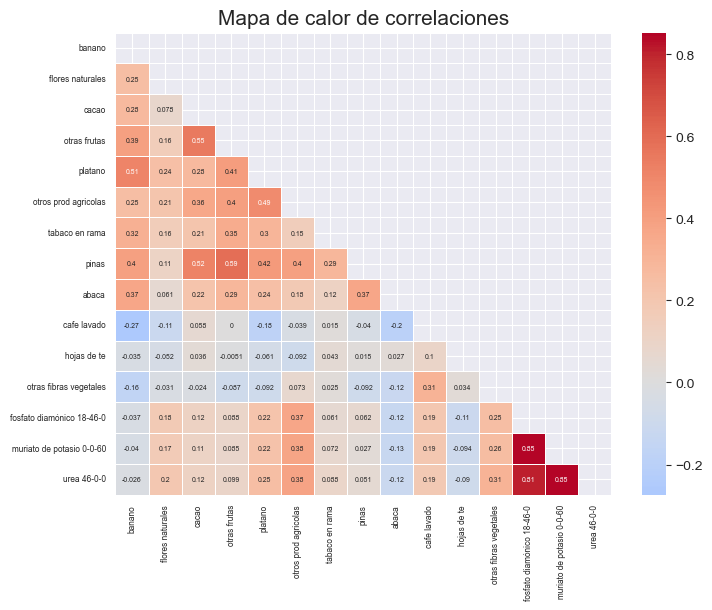

In [250]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
exportaciones_y_fertilizantes = X_exportaciones.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = exportaciones_y_fertilizantes.corr(method="kendall")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

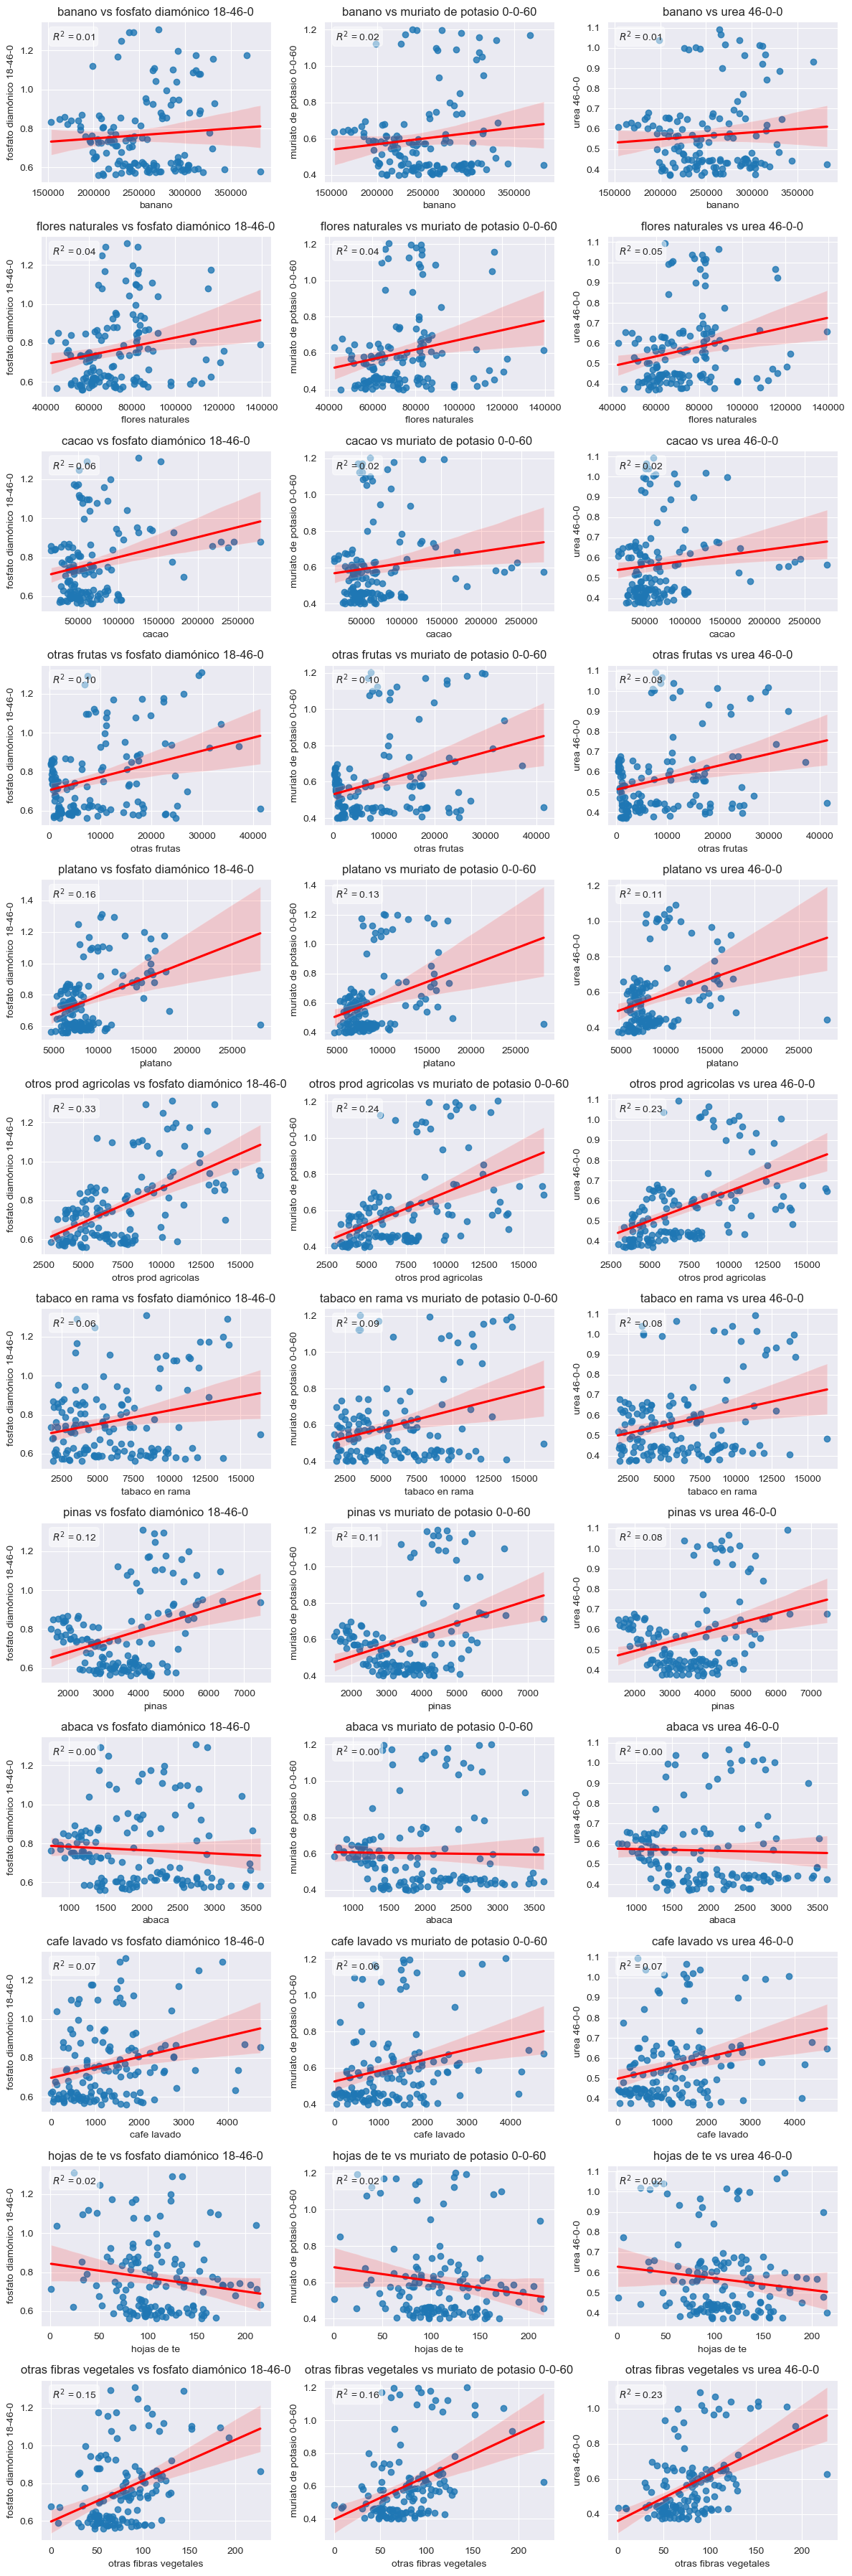

In [251]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Listas de columnas
columnas_x = X_exportaciones.columns
columnas_y = precios_fertilizantes.columns

# Crear una lista de todos los pares posibles
pares = list(itertools.product(columnas_x, columnas_y))

# Definir el tamaño de la cuadrícula de subplots
num_columnas = 3
num_filas = (len(pares) + num_columnas - 1) // num_columnas

# Crear los subplots
fig, axes = plt.subplots(nrows=num_filas, ncols=num_columnas, figsize=(4 * num_columnas, 3 * num_filas))

# Aplanar el arreglo de ejes para iterar fácilmente
axes = axes.flatten()

for ax, (columna_x, columna_y) in zip(axes, pares):
    # Extraer los datos sin valores faltantes
    datos = exportaciones_y_fertilizantes[[columna_x, columna_y]].dropna()
    
    # Verificar que hay suficientes datos para ajustar el modelo
    if len(datos) > 1:
        x = datos[columna_x].values.reshape(-1, 1)
        y = datos[columna_y].values
        
        # Ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x, y)
        
        # Predicciones y cálculo del R²
        y_pred = modelo.predict(x)
        r2 = r2_score(y, y_pred)
        
        # Crear el gráfico de dispersión con línea de regresión
        sns.regplot(x=columna_x, y=columna_y, data=datos, ax=ax, line_kws={'color': 'red'})
        
        # Agregar el valor de R² en el gráfico
        ax.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        ax.set_xlabel(columna_x)
        ax.set_ylabel(columna_y)
        ax.set_title(f'{columna_x} vs {columna_y}')
    else:
        # Si no hay suficientes datos, mostrar un mensaje
        ax.text(0.5, 0.5, 'Datos insuficientes', horizontalalignment='center', verticalalignment='center')
        ax.set_xlabel(columna_x)
        ax.set_ylabel(columna_y)
        ax.set_title(f'{columna_x} vs {columna_y}')
    
# Eliminar ejes vacíos si los hay
for ax in axes[len(pares):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [252]:
productos_exportados_de_interés = X_exportaciones[['otros prod agricolas']]\
    .rename(columns={'otros prod agricolas':'otros_prod_agrícolas_exportados'})

### Subsidio urea

Fuente: https://www.agricultura.gob.ec/agricultores-pagaran-el-50-del-costo-comercial-del-saco-de-urea/

In [44]:
index_subsidio = pd.date_range(start=primer_mes_análisis, end=último_mes_análisis, freq='ME')

subsidio_urea = pd.DataFrame(index=index_subsidio, columns=['tiene_subsidio_urea'])
subsidio_urea['tiene_subsidio_urea'] = False

# Meses en los que hay subsidio de urea:
meses_con_subsidio = pd.date_range(start='2022-07', end='2024-01', freq='ME')

# Marca como True los meses en los que hay subsidio de urea
subsidio_urea.loc[meses_con_subsidio, 'tiene_subsidio_urea'] = True

### Unir DataFrames

In [253]:
frames = [fob_urea_mar_rojo, precio_commodities_Europa, inflación_mensual_nacional, ipc_diesel_imp, datos_climáticos, productos_exportados_de_interés, precios_fertilizantes]

for frame in frames:
    print("Rango de fechas:", frame.index.min(), " a ", frame.index.max())

Rango de fechas: 2013-01-31 00:00:00  a  2024-04-30 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2023-12-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2024-08-31 00:00:00


In [254]:
# Unir todas las variables en un solo DataFrame:
df = pd.concat(frames, axis=1)

# Eliminar valores nulos:
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Freq: ME
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fob_urea_kg                       132 non-null    float64
 1   crude_oil_brent_usd_per_bbl       132 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu  132 non-null    float64
 3   inflación_mensual                 132 non-null    float64
 4   diesel                            132 non-null    float64
 5   precipitación_media_mm            132 non-null    float64
 6   temp_media_Celsius                132 non-null    float64
 7   otros_prod_agrícolas_exportados   132 non-null    float64
 8   fosfato diamónico 18-46-0         132 non-null    float64
 9   muriato de potasio 0-0-60         132 non-null    float64
 10  urea 46-0-0                       132 non-null    float64
dtypes: float64(11)
memory usage: 12.4 KB


### Diferenciación no-estacional y estacional

#### Estacionareidad por *Dickey-Fuller* y *Kwiatkowski-Phillips-Schmidt-Shin*

In [256]:
df_test_estacionareidad = evaluar_estacionareidad(df)

df_test_estacionareidad

variable  valor_p_adfuller  valor_p_kpss  \
0                        fob_urea_kg      2.361962e-01      0.022258   
1        crude_oil_brent_usd_per_bbl      1.067201e-01      0.100000   
2   natural_gas_europe_usd_per_mmbtu      2.756353e-01      0.031976   
3                  inflación_mensual      7.021729e-13      0.079594   
4                             diesel      9.639810e-01      0.010000   
5             precipitación_media_mm      1.298639e-01      0.100000   
6                 temp_media_Celsius      5.043799e-01      0.100000   
7    otros_prod_agrícolas_exportados      9.990506e-01      0.010000   
8          fosfato diamónico 18-46-0      3.972852e-01      0.023077   
9          muriato de potasio 0-0-60      4.079042e-01      0.019878   
10                       urea 46-0-0      1.437393e-01      0.023705   

    adfuller_rechazar_H0  kpss_rechazar_H0 estado_estacionario  
0                  False              True     No estacionario  
1                  False             False            No claro  
2                  False              True     No estacionario  
3                   True             False        Estacionario  
4                  False              True     No estacionario  
5                  False             False            No claro  
6                  False             False            No claro  
7                  False              True     No estacionario  
8                  False              True     No estacionario  
9                  False              True     No estacionario  
10                 False              True     No estacionario

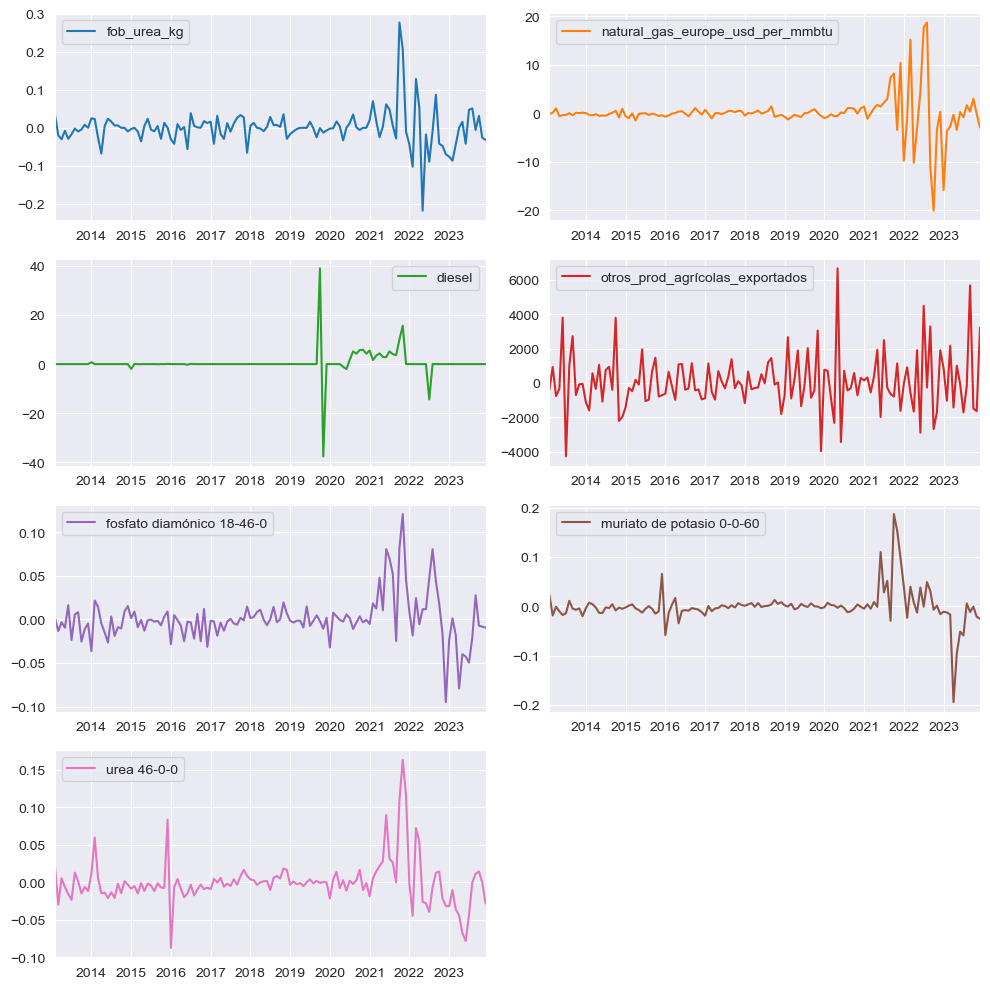

In [257]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

variables_no_estacionarias = df_test_estacionareidad.query("estado_estacionario == 'No estacionario'")['variable'].values

df_no_estacionarias = df[variables_no_estacionarias]

df_diferenciadas = pd.DataFrame(index=pd.date_range(start='2013-02', end='2024-01', freq='ME'))

for col in variables_no_estacionarias:
    
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df_no_estacionarias[col])
    
    df_diferenciadas[col] = np.diff(df_no_estacionarias[col], n=d)

df_diferenciadas.plot(
    subplots=True,
    layout=(int(np.ceil(len(variables_no_estacionarias)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

In [258]:
df_diferenciadas_test = evaluar_estacionareidad(df_diferenciadas)

df_diferenciadas_test

variable  valor_p_adfuller  valor_p_kpss  \
0                       fob_urea_kg      5.766319e-04      0.100000   
1  natural_gas_europe_usd_per_mmbtu      1.462501e-05      0.100000   
2                            diesel      5.673885e-28      0.100000   
3   otros_prod_agrícolas_exportados      2.730360e-01      0.041667   
4         fosfato diamónico 18-46-0      1.256858e-02      0.100000   
5         muriato de potasio 0-0-60      4.067098e-05      0.100000   
6                       urea 46-0-0      6.081601e-02      0.100000   

   adfuller_rechazar_H0  kpss_rechazar_H0 estado_estacionario  
0                  True             False        Estacionario  
1                  True             False        Estacionario  
2                  True             False        Estacionario  
3                 False              True     No estacionario  
4                  True             False        Estacionario  
5                  True             False        Estacionario  
6                 False             False            No claro

In [259]:
variables_originalmente_estacionarias = df[
    df_test_estacionareidad\
    .query("estado_estacionario == 'Estacionario'")\
    ['variable']\
    .values
    ]

variables_exitosamente_diferenciadas = df_diferenciadas[
    df_diferenciadas_test\
    .query("estado_estacionario == 'Estacionario'")\
    ['variable']\
    .values
    ]

df_estacionarias = pd.concat(
    [variables_originalmente_estacionarias,
     variables_exitosamente_diferenciadas],
    axis=1)\
    .dropna()
# df_capped = fertilizantes_utils.apply_outlier_capping()

In [260]:
df_estacionarias

inflación_mensual  fob_urea_kg  natural_gas_europe_usd_per_mmbtu  \
2013-02-28           0.001847      0.03563                         -0.100000   
2013-03-31           0.004384     -0.02000                          0.100000   
2013-04-30           0.001790     -0.03000                          1.010000   
2013-05-31          -0.002179     -0.00750                         -0.590000   
2013-06-30          -0.001448     -0.02875                         -0.370000   
...                       ...          ...                               ...   
2023-08-31           0.005030      0.05100                          1.646661   
2023-09-30           0.000379     -0.00563                          0.357351   
2023-10-31          -0.001750      0.03138                          3.020212   
2023-11-30          -0.003992     -0.02588                         -0.084452   
2023-12-31          -0.000232     -0.03150                         -2.978397   

            diesel  fosfato diamónico 18-46-0  muriato de potasio 0-0-60  
2013-02-28     0.0                   0.001287                   0.022996  
2013-03-31     0.0                  -0.013467                  -0.018714  
2013-04-30     0.0                  -0.003269                  -0.000789  
2013-05-31     0.0                  -0.009564                  -0.010240  
2013-06-30     0.0                   0.016257                  -0.017747  
...            ...                        ...                        ...  
2023-08-31     0.0                  -0.020711                   0.005784  
2023-09-30     0.0                   0.027541                  -0.011439  
2023-10-31     0.0                  -0.007235                  -0.000758  
2023-11-30     0.0                  -0.008311                  -0.021318  
2023-12-31     0.0                  -0.009468                  -0.025201  

[131 rows x 6 columns]

In [261]:
def apply_outlier_capping(series, multiplier=1.5):
    """
    Aplica capping a los valores atípicos de una serie.

    Parámetros:
    - series (pd.Series): Serie de entrada.
    - multiplier (float): Multiplicador para el IQR para determinar los límites de capping. Default es 1.5.

    Devuelve:
    - pd.Series: Serie con capping aplicado.
    """
    
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites
    upper_limit = Q3 + multiplier * IQR
    lower_limit = Q1 - multiplier * IQR

    # Aplicar capping
    series_capped = series.clip(lower=lower_limit, upper=upper_limit)
    
    return pd.Series(series_capped)

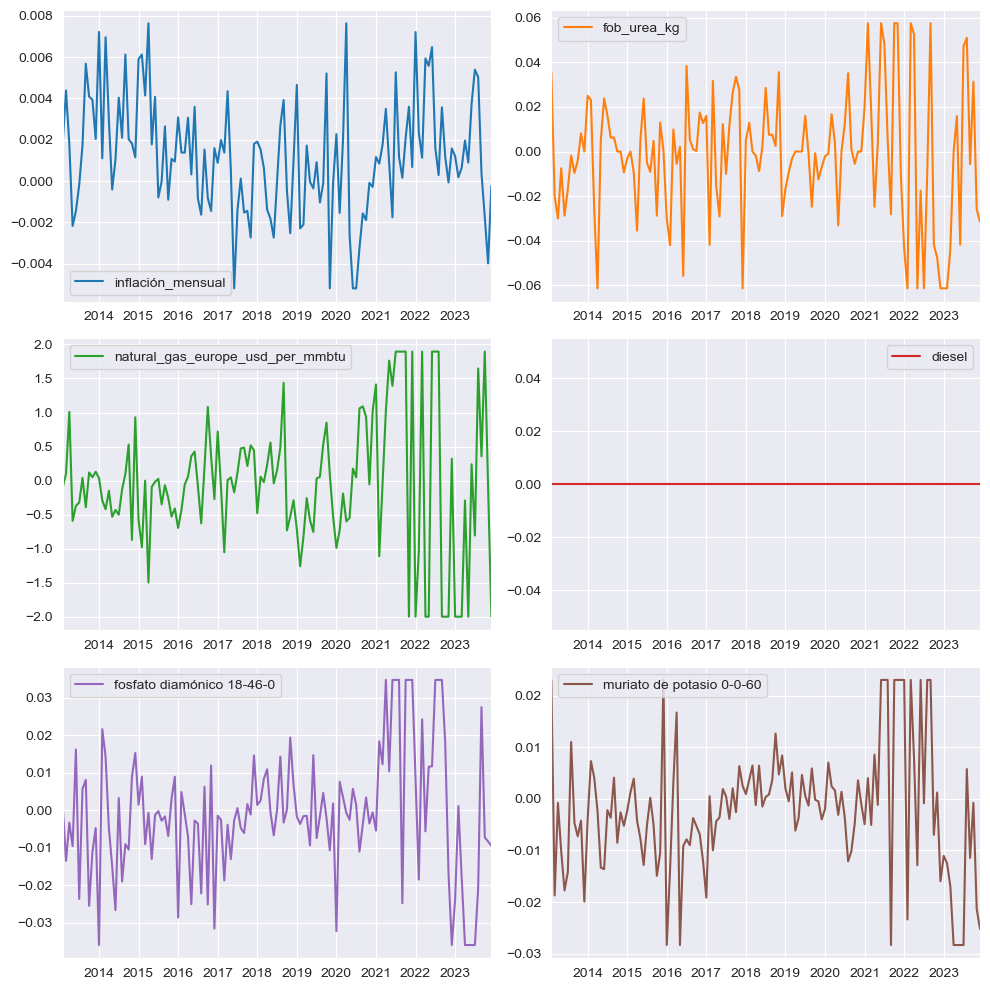

In [262]:

df_capped = pd.DataFrame(index=df_estacionarias.index)

multiplicador = 1.5

for col in df_estacionarias.columns:
    df_capped[col] = apply_outlier_capping(df_estacionarias[col], multiplier=multiplicador)
df_capped.plot(
    subplots=True,
    layout=(int(np.ceil(len(df_capped.columns)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

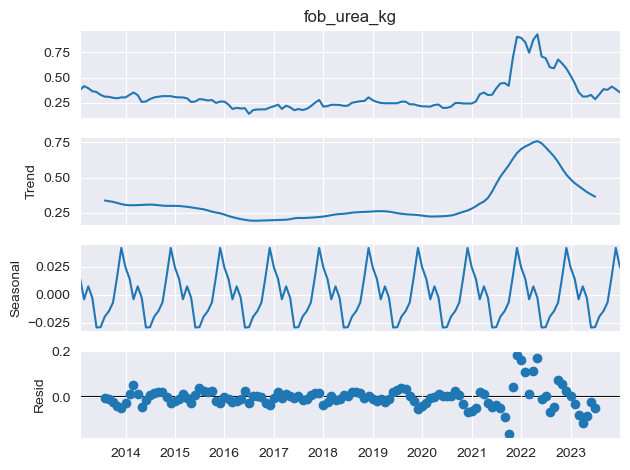

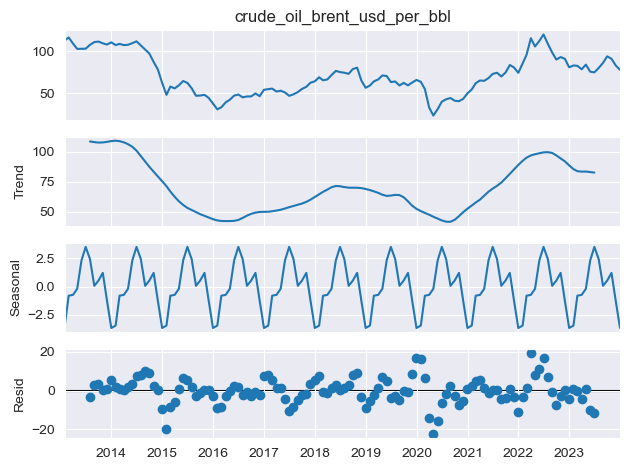

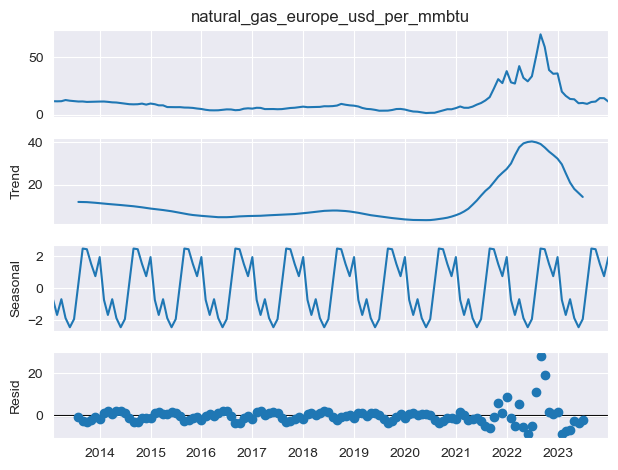

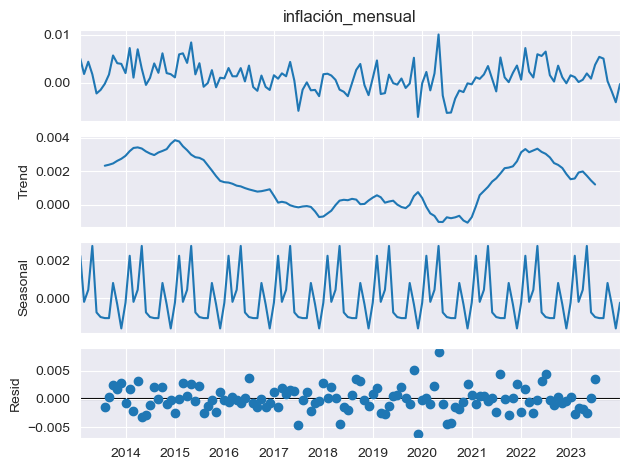

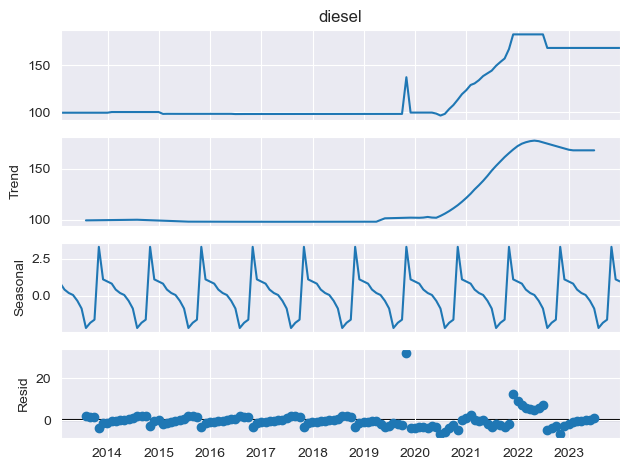

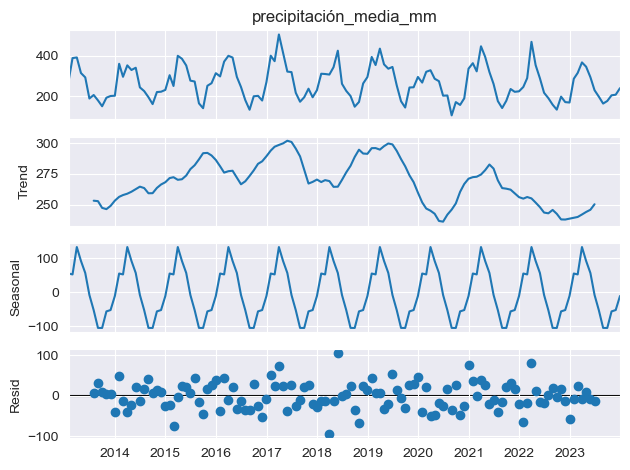

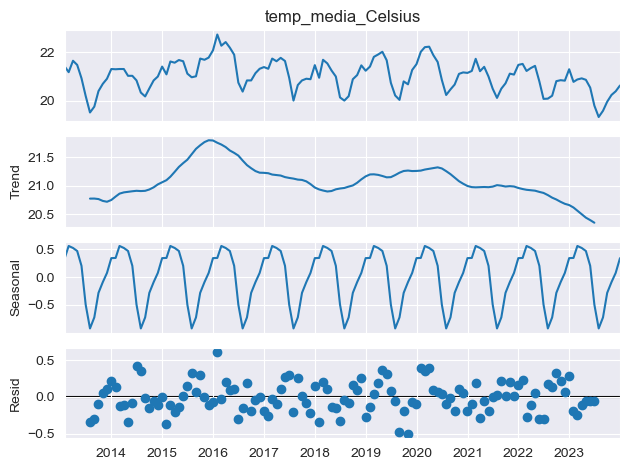

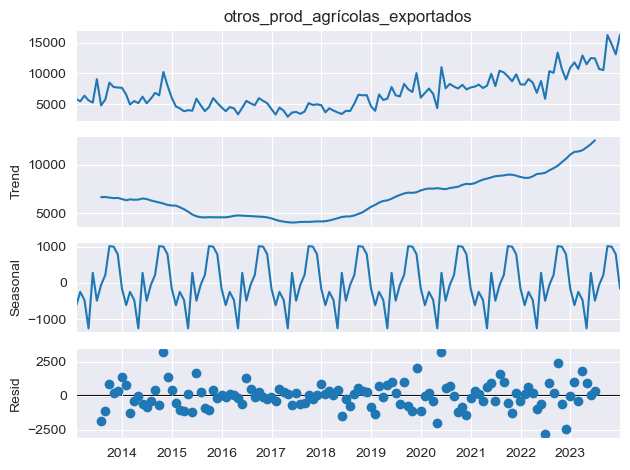

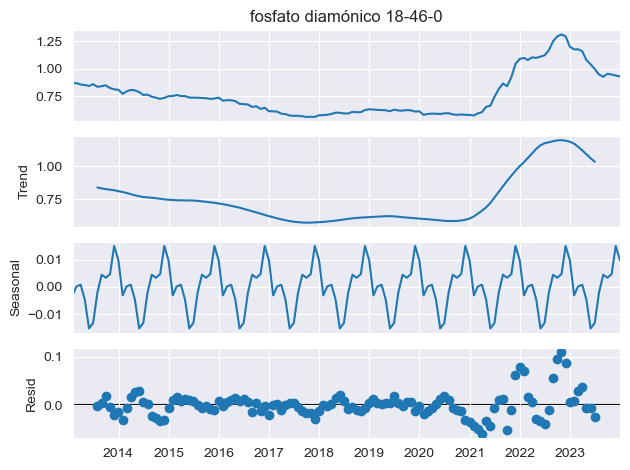

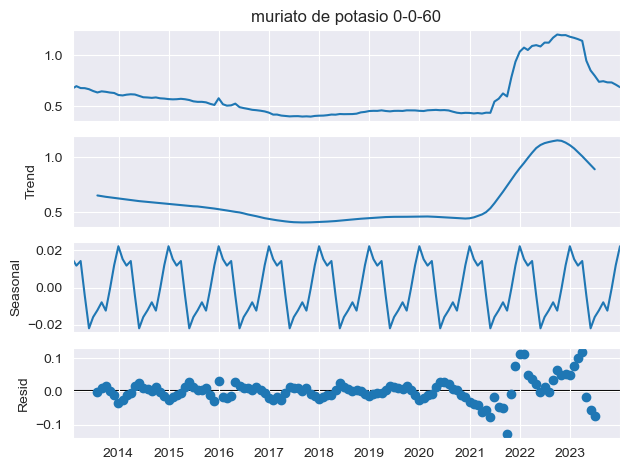

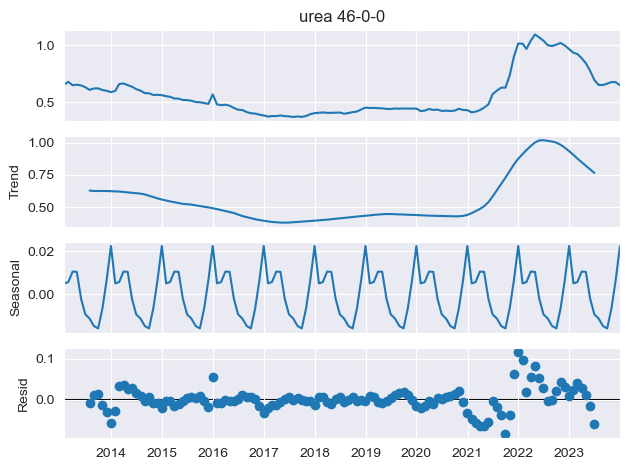

In [263]:
from statsmodels.tsa.seasonal import seasonal_decompose

for col in df.columns:
    decomposition = seasonal_decompose(df[col], model='additive', period=12)
    decomposition.plot()

In [264]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

diffs_dict = {}

for col in df.columns:
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df[col])

    # Determinar el número de diferenciaciones estacionales
    D = nsdiffs(df[col], m=12)
    
    # Almacenar valores de diferenciación:
    diffs_dict[col] = {
        'D' : D,
        'd' : d
        }

diffs_dict

{'fob_urea_kg': {'D': 0, 'd': 1},
 'crude_oil_brent_usd_per_bbl': {'D': 0, 'd': 0},
 'natural_gas_europe_usd_per_mmbtu': {'D': 0, 'd': 1},
 'inflación_mensual': {'D': 0, 'd': 0},
 'diesel': {'D': 0, 'd': 1},
 'precipitación_media_mm': {'D': 0, 'd': 0},
 'temp_media_Celsius': {'D': 0, 'd': 0},
 'otros_prod_agrícolas_exportados': {'D': 0, 'd': 1},
 'fosfato diamónico 18-46-0': {'D': 0, 'd': 1},
 'muriato de potasio 0-0-60': {'D': 0, 'd': 1},
 'urea 46-0-0': {'D': 0, 'd': 1}}

### Limpieza de series de tiempo

In [265]:
def percent_change(values):
    """
    Calcula el porcentaje de cambio entre el último valor y la media de los valores previos
    """
    previous_values = values[:-1]
    last_value = values[-1]
    pct_change = (last_value - np.mean(previous_values))\
        / np.mean(previous_values)
    return pct_change

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


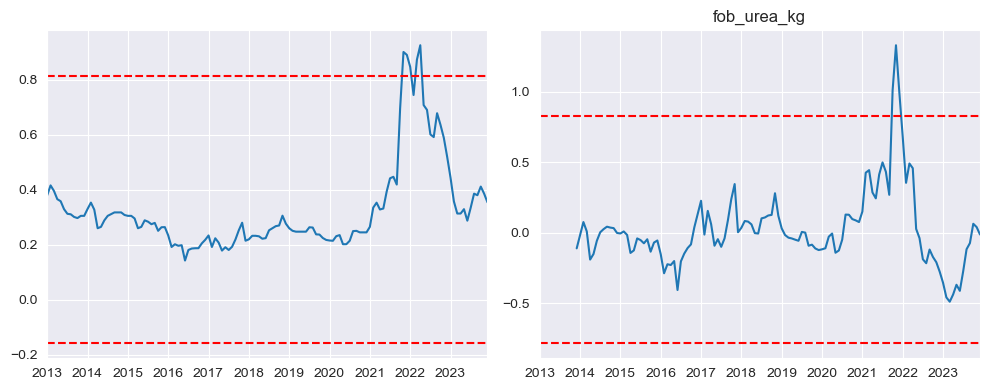

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


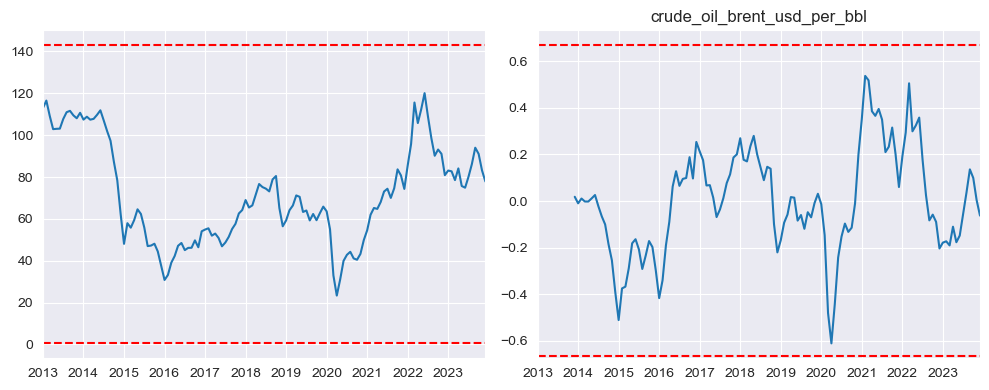

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


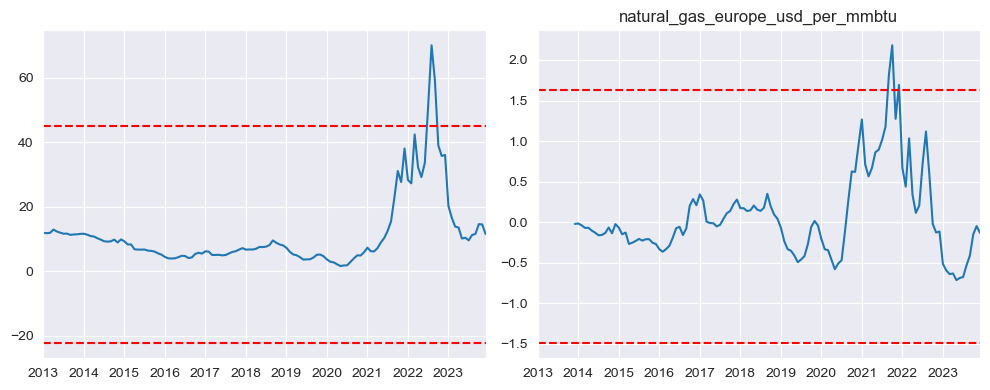

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


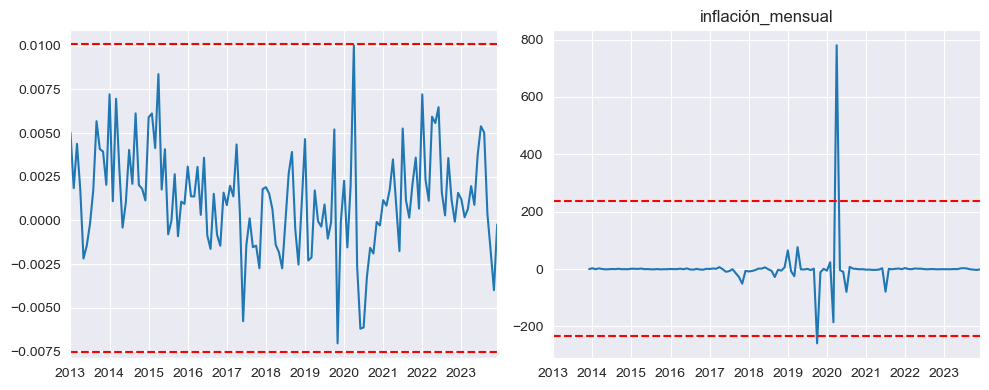

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


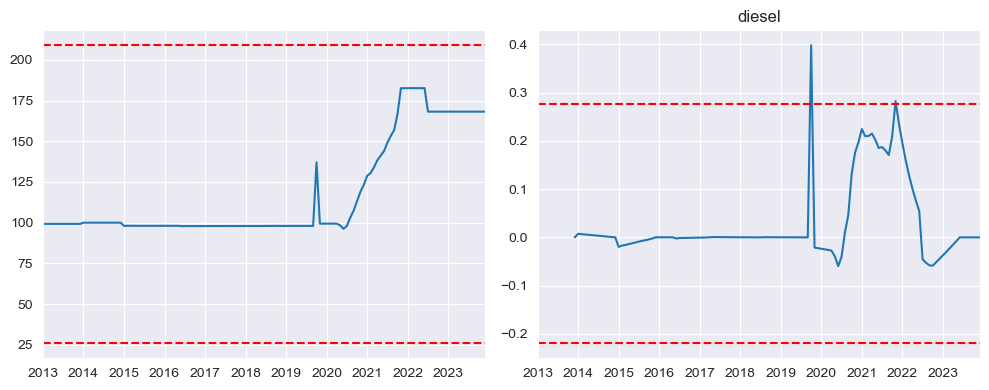

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


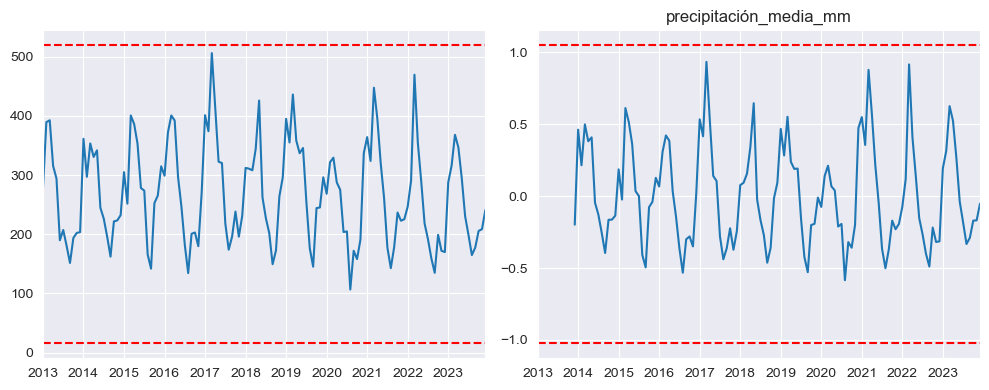

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


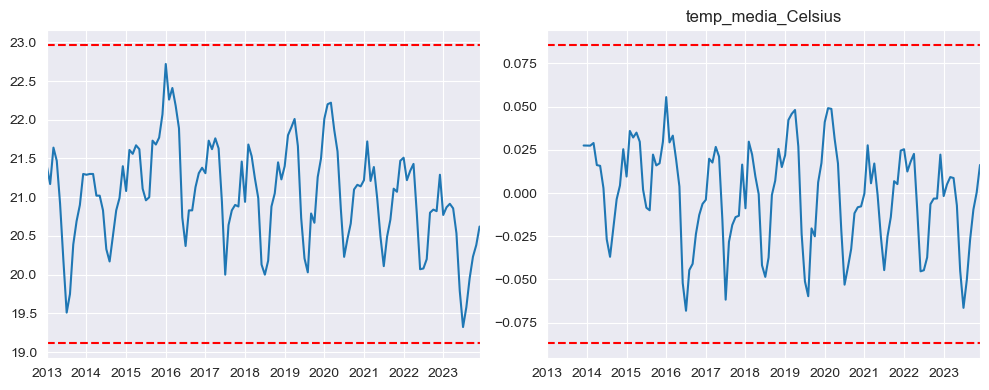

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


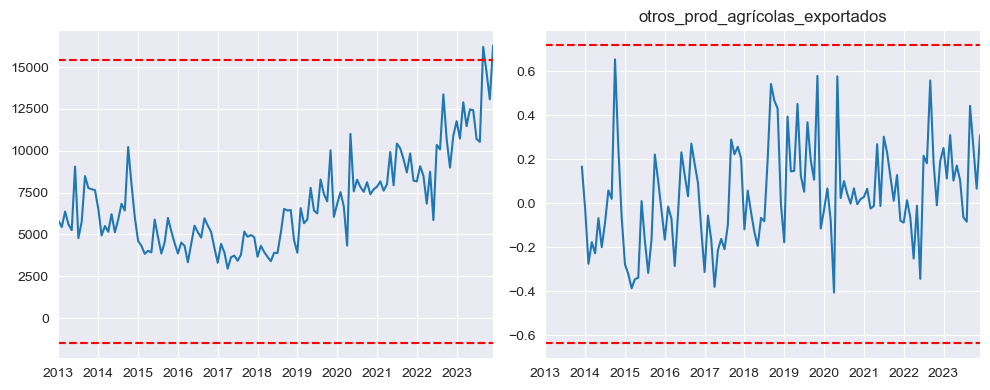

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


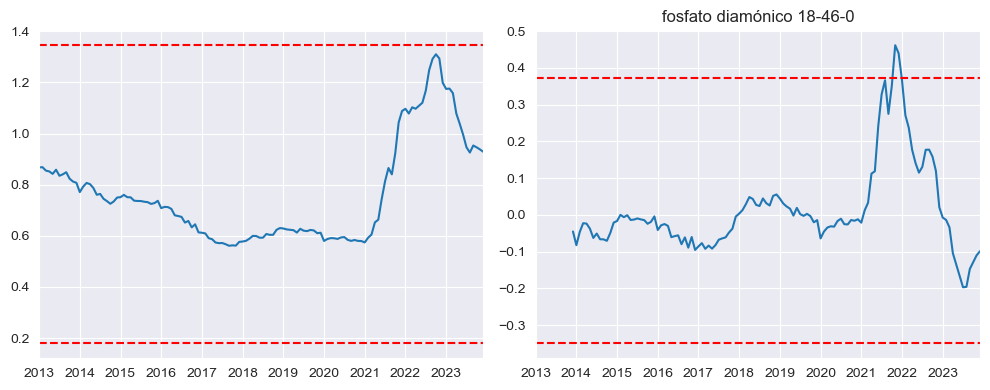

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


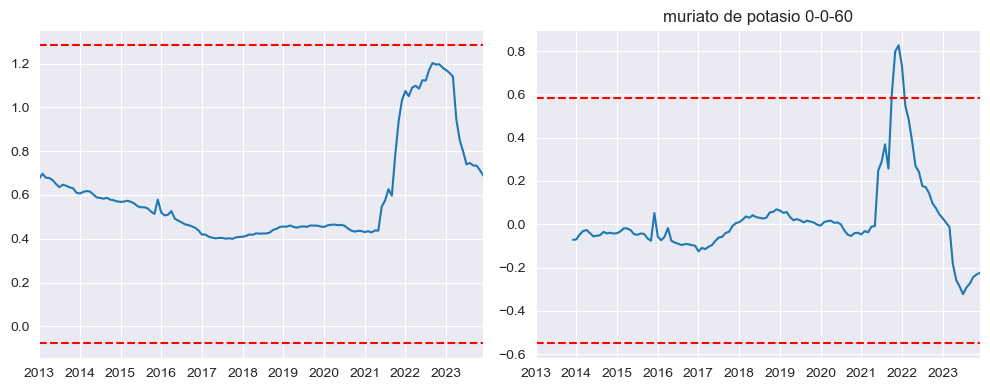

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2426151628.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_value = values[-1]


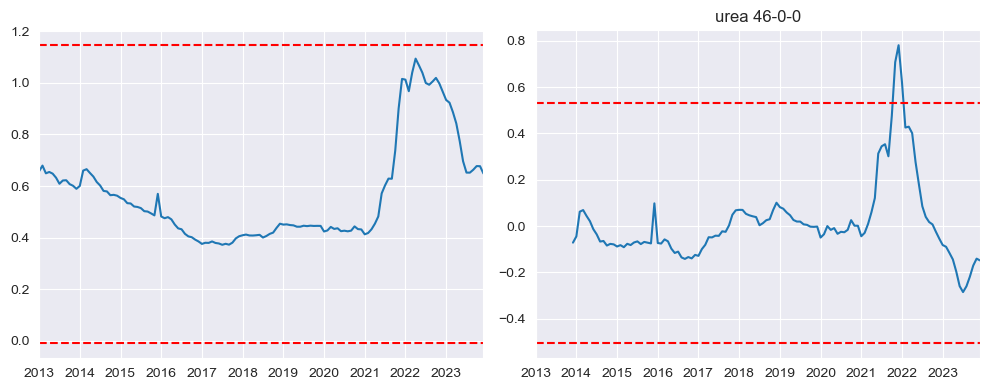

In [266]:
cambio_porcentual_precios = df.copy()

for col in cambio_porcentual_precios.columns:
    cambio_porcentual_precios[col] = cambio_porcentual_precios[col]\
        .rolling(window=12)\
        .aggregate(percent_change)
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Iteramos sobre ambas series de tiempo:
    for data, ax in zip([df[col], cambio_porcentual_precios[col]], axs):
        
        # Calculamos media y desviación estándar:
        mean = data.mean()
        std = data.std()
        
        # Graficamos los datos con un marcador de 3 desviaciones estándar:
        data.plot(ax=ax)
        ax.axhline(mean + std * 3, ls="--", c="r")
        ax.axhline(mean - std * 3, ls="--", c="r")
        
    plt.title(col)
    plt.tight_layout()    
    plt.show()

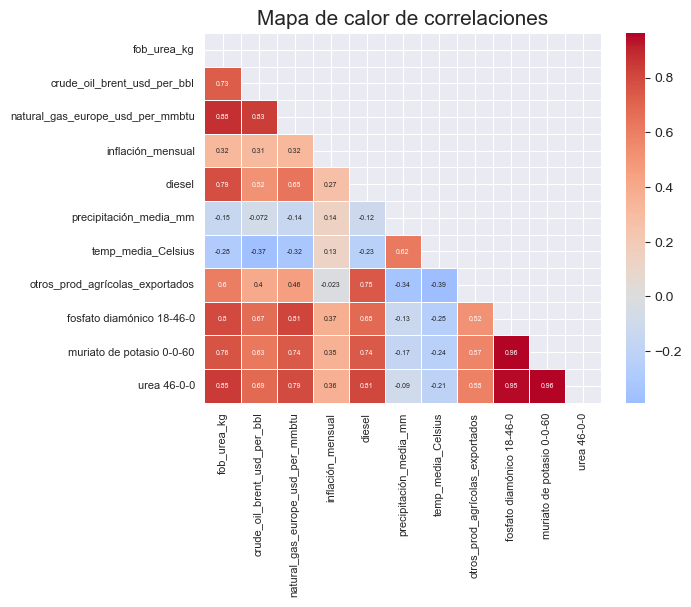

In [267]:
# Graficar mapa de calor de correlaciones no lineales:
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

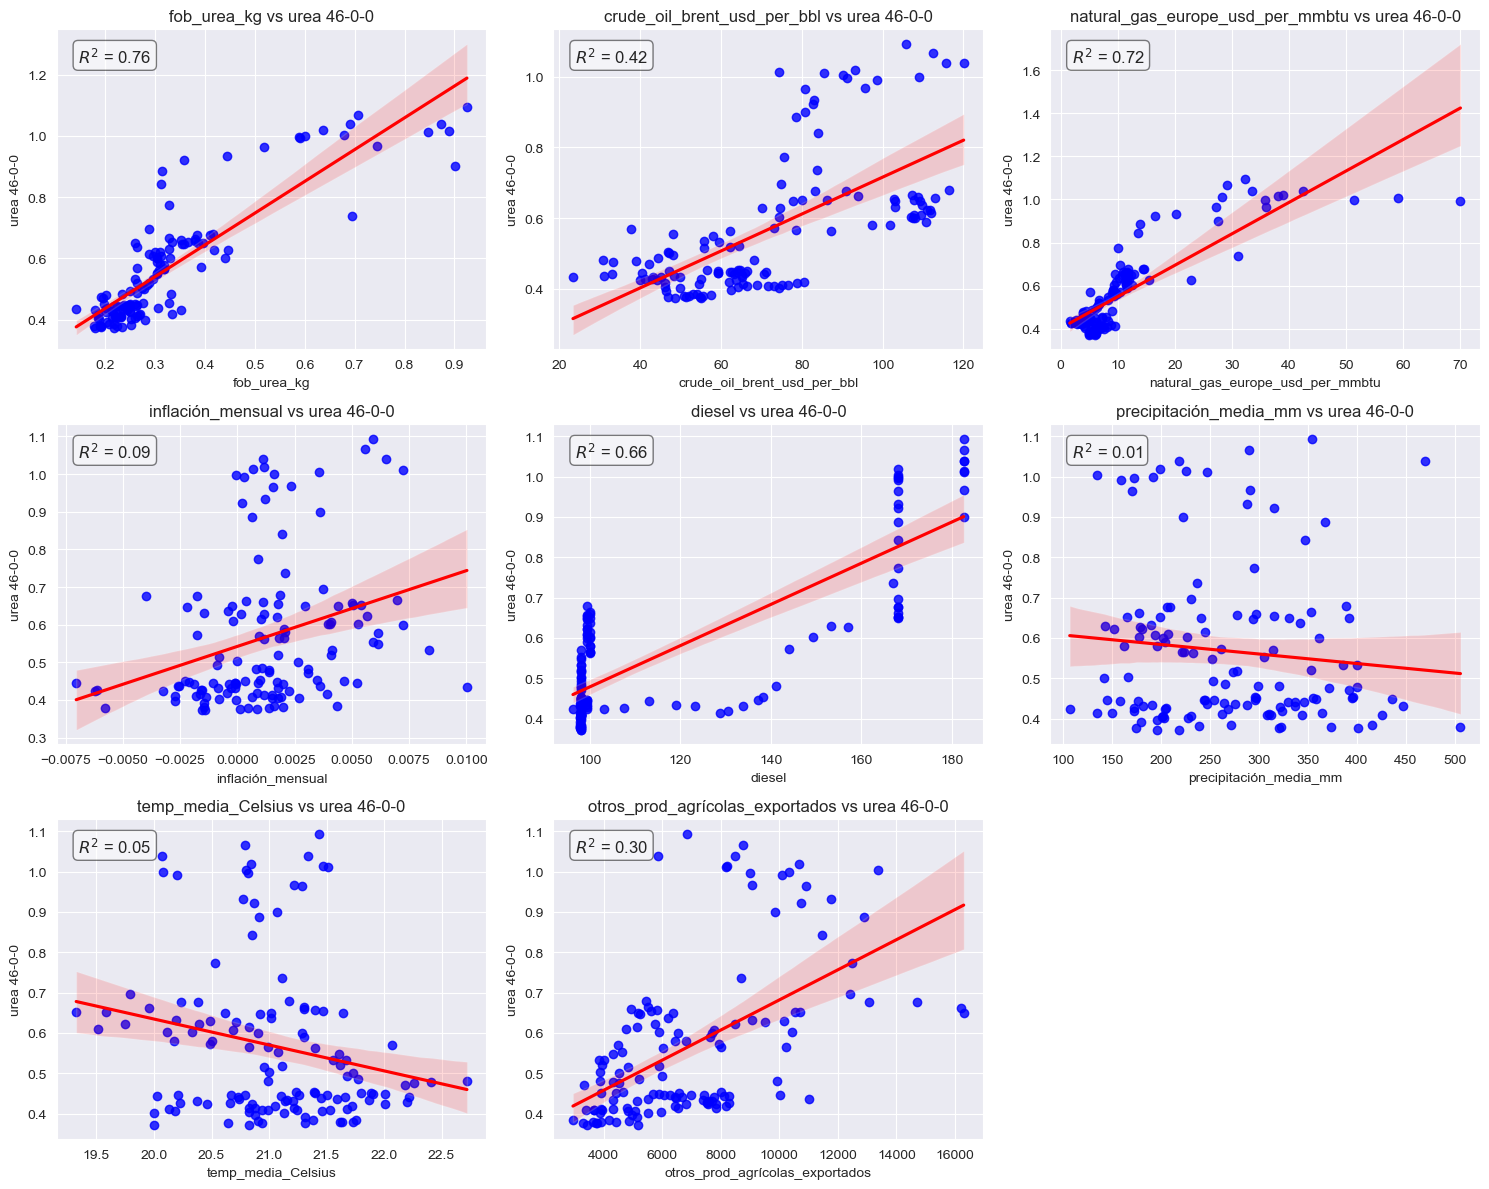

In [270]:
Y_list = precios_fertilizantes.columns.to_list()
target_var= 'urea 46-0-0'

X = df.drop(columns=Y_list)
y = df[target_var]

# Número de características en X
num_features = X.shape[1]

# Determinar el número de filas y columnas para la cuadrícula
num_rows = int(np.ceil(np.sqrt(num_features)))
num_cols = int(np.ceil(num_features / num_rows))

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

# Si solo hay una característica, convertir axes en una lista
if num_features == 1:
    axes = [axes]

# Aplanar la lista de ejes para facilitar la iteración
axes = np.array(axes).flatten()

# Iterar sobre cada característica y crear un diagrama de dispersión con línea de regresión y R²
for i, col in enumerate(X.columns):
    ax = axes[i]
    
    # Seleccionar datos sin NaN para la variable actual
    df_plot = df[[col, target_var]].dropna()
    X_col = df_plot[col].values.reshape(-1, 1)
    y_col = df_plot[target_var].values
    
    # Ajustar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_col, y_col)
    y_pred = model.predict(X_col)
    r2 = r2_score(y_col, y_pred)
    
    # Graficar el diagrama de dispersión con línea de regresión
    sns.regplot(x=col, y=target_var, data=df_plot, ax=ax, color='blue', line_kws={"color": "red"})
    
    # Anotar el valor de R² en el subplot
    ax.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
                                                           edgecolor='black', facecolor='white', alpha=0.5))
    
    # Establecer título y etiquetas
    ax.set_title(f'{col} vs {target_var}')
    ax.set_xlabel(col)
    ax.set_ylabel(target_var)

# Eliminar cualquier eje adicional que no se use
for j in range(num_features, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Número de variables
n_vars = df.shape[1]

# Creamos una cuadrícula de subgráficos:
fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

for i, column in enumerate(df.columns):
    plot_acf(df[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de '{column}'")
    plot_pacf(df[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de '{column}'")

plt.tight_layout()
plt.show()

In [ ]:
# Obtener las variables características regularizadas con una constante:
const_X = sm.add_constant(X)

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(y, const_X).fit(cov_type='HC3')
print(model.summary())

#### Transformación logarítmica

C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_6488\2801453290.py:6: RuntimeWarning: invalid value encountered in log
  df_ln["ln_"+ col] = np.log(df[col].values)


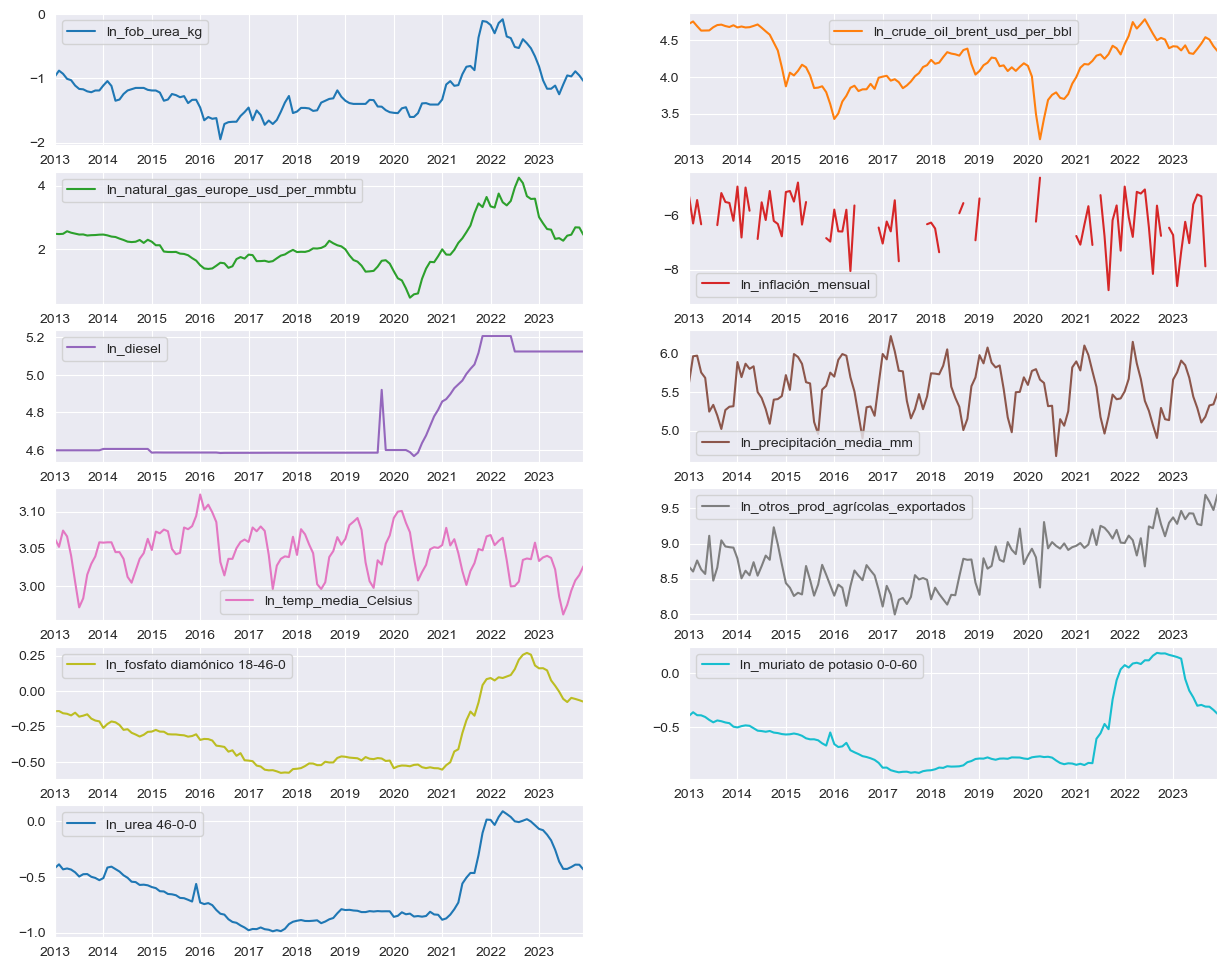

In [274]:
df_ln = pd.DataFrame()

df_ln.index = df.index.copy()

for col in df.columns:
    df_ln["ln_"+ col] = np.log(df[col].values)

num_de_filas = ((df_ln.shape[1] + 1) // 2)

df_ln.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()